# Import Libraries

In [1]:
# pip install -q phonenumbers
# !pip install shap

In [2]:
# Snowpark for Python
from snowflake.snowpark import Session
from snowflake.snowpark.version import VERSION
import snowflake.snowpark.functions as F
from snowflake.snowpark.types import DecimalType

# Snowpark ML
import snowflake.ml.modeling.preprocessing as snowml
from snowflake.ml.modeling.pipeline import Pipeline
from snowflake.ml.modeling.metrics.correlation import correlation

from snowflake.ml.modeling.xgboost import XGBRegressor
from snowflake.ml.modeling.xgboost import XGBClassifier
from snowflake.ml.modeling.model_selection import GridSearchCV
from snowflake.ml.registry import model_registry
from snowflake.ml._internal.utils import identifier
# from xgboost import XGBClassifier

# Data Science Libs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from snowflake.ml.modeling.metrics import mean_absolute_percentage_error
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Misc
import json
import joblib
import cachetools

# warning suppresion
import warnings; warnings.simplefilter('ignore')

import phonenumbers

import shap

# Data preparation
## Connect to snowflake

In [3]:
# Make a Snowpark Connection

connection_parameters = json.load(open('connection.json'))
session = Session.builder.configs(connection_parameters).create()
session.sql_simplifier_enabled = True

snowflake_environment = session.sql('SELECT current_user(), current_version()').collect()
snowpark_version = VERSION

# Current Environment Details
print('\nConnection Established with the following parameters:')
print('User                        : {}'.format(snowflake_environment[0][0]))
print('Role                        : {}'.format(session.get_current_role()))
print('Database                    : {}'.format(session.get_current_database()))
print('Schema                      : {}'.format(session.get_current_schema()))
print('Warehouse                   : {}'.format(session.get_current_warehouse()))
print('Snowflake version           : {}'.format(snowflake_environment[0][1]))
print('Snowpark for Python version : {}.{}.{}'.format(snowpark_version[0],snowpark_version[1],snowpark_version[2]))


Connection Established with the following parameters:
User                        : MARK1971
Role                        : "ACCOUNTADMIN"
Database                    : "YALA_DB"
Schema                      : "PUBLIC"
Warehouse                   : "COMPUTE_WH"
Snowflake version           : 7.43.0
Snowpark for Python version : 1.9.0


In [4]:
# Specify the table name where we stored the diamonds dataset
# **nChange this only if you named your table something else in the data ingest notebook **
CONVERTEDONLY_LEADS_TABLE = 'CONVERTEDONLY'
# TENTS_BY_LEADS_TABLE = 'TENTS_BY_LEAD'
input_tbl1 = f"{session.get_current_database()}.{session.get_current_schema()}.{CONVERTEDONLY_LEADS_TABLE}"
# input_tbl2 = f"{session.get_current_database()}.{session.get_current_schema()}.{TENTS_BY_LEADS_TABLE}"

In [5]:
# First, we read in the data from a Snowflake table into a Snowpark DataFrame
leads_df = session.table(input_tbl1)
# tents_df = session.table(input_tbl2)

In [6]:
# leads_df.show()
# tents_df.show()


In [7]:
# def fix_values(columnn):
#     return F.upper(F.regexp_replace(F.col(columnn), '[^a-zA-Z0-9]+', '_'))

# for col in ["VALUE"]:
#     tents_df = tents_df.with_column(col, fix_values(col))

In [8]:
# from snowflake.snowpark.functions import col, sum as sum_

# # Apply OneHotEncoder
# snowml_ohe = snowml.OneHotEncoder(input_cols=["VALUE"], output_cols=['TNT'])
# df_encoded = snowml_ohe.fit(tents_df).transform(tents_df)

# # The OneHotEncoder might create new columns with specific names. 
# # Let's find out the names of these new columns.
# new_columns = [c for c in df_encoded.columns if c not in tents_df.columns]

# # Group by LEADID and aggregate
# df_tents_grouped = df_encoded.groupBy("LEADID").agg(*[sum_(col(c)).alias(c) for c in new_columns])
  
# # Show the result
# df_tents_grouped.show()

In [9]:
# df_tents_grouped.write.mode('overwrite').save_as_table('tents_encoded')

In [10]:
# def fix_values(columnn):
#     return F.upper(F.regexp_replace(F.col(columnn), '[^a-zA-Z0-9]+', '_'))

# for col in ["ADDRESSCOUNTRY"]:
#     leads_df = leads_df.with_column(col, fix_values(col))

# leads_df.show()

## Drop features without values

In [11]:
leads_df = leads_df.drop('SALUTATION'
,'TITLE'
,'FIRSTNAME'
,'LASTNAME'
,'WEBSITE'
,'CONVERTEDCONTACTID'
,'CONVERTEDDATE'
,'CONVERTEDCONTACTID'
,'CONVERTEDORGANIZATIONID'
,'UPDATEDDATE'
,'EMPLOYEECOUNT'
,'LEADRATING'
,'FAX'
,'INDUSTRY'
,'OWNERUSERID'
,'RESPONSIBLEUSERID'
,'ADDRESSSTREET'
,'ADDRESSCITY'
,'ADDRESSSTATE'
,'ADDRESSPOSTCODE'
,'LASTACTIVITYDATE'
,'NEXTACTIVITYDATE'
,'VISIBLETO'
,'VISIBLETEAMID'
,'ORGANIZATIONNAME'
,'CREATEDUSERID'
,'IMAGEURL'
,'TAGS'
,'O_ID'
,'CONVERTED'
# ,'CUSTOMFIELDS'
,'LEADSTATUSID'
,'MOBILE'
,'PHONE'
,'CONVERTEDOPPORTUNITYID')


## Fill Email with default value once empty

In [12]:
# Checking for missing values in the leads_df EMAIL dataframe column
leads_df = leads_df.na.replace('', "unknown@unknown.nl", subset='EMAIL')
# leads_df.write.mode('overwrite').save_as_table('tmp_leadsonly')
# leads_df.show()
print(leads_df.columns)
leads_df.show()

['ID', 'LEADSOURCEID', 'CREATEDDATE', 'EMAIL', 'LEADDESCRIPTION', 'ADDRESSCOUNTRY', 'CUSTOMFIELDS', 'O_OPPORTUNITYSTATE']
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"ID"      |"LEADSOURCEID"  |"CREATEDDATE"          |"EMAIL"                       |"LEADDESCRIPTION"                                   |"ADDRESSCOUNTRY"  |"CUSTOMFIELDS"                                      |"O_OPPORTUNITYSTATE"  |
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|45435089  |2973396         |9/11/2019 1:45:07 PM   |unknown@unknown.nl            |                                                    |                  |[{"FIELD_NAME":"Event__

## Create new column with Email domain only

In [13]:
# List of identified private email domains
private_domains = [
    'gmail.com', 'hotmail.com', 'orange.fr', 'wanadoo.fr', 'hotmail.fr',
    'yahoo.com', 'outlook.com', 'hotmail.co.uk', 'me.com', 'gmx.de',
    'icloud.com', 'yahoo.it', 'libero.it', 'web.de', 'kpnmail.nl',
    'yahoo.de', 'yahoo.fr', 'free.fr', 'telenet.be', 'live.fr',
    'otenet.gr', 'mac.com', 'yahoo.co.uk', 'laposte.net', 'uol.com.br',
    'casema.nl', 'aol.com', 't-online.de', 'unknown.com', 'yahoo.in',
    'gmx.fr', 'mail.com', 'mail.ru', 'live.it', 'msn.com',
    'yahoo.com.sg', 'hotmail.it', 'googlemail.com', 'hotmail.nl', 'ziggo.nl'
]

# Extracting the domain from the 'Email' column
leads_df = leads_df.withColumn(
    "Email_Domain",
    F.regexp_extract(F.col("Email"), '@([a-zA-Z0-9.-]+)$', 1)
)


## Create new column with tagging it as BUSINESS or PRIVATE

In [14]:
# Classifying the email addresses as 'Private' or 'Business'
# merged_data_prefixed['c_Email_Type'] = merged_data_prefixed['c_Email_Domain'].apply(
#     lambda x: 'Private' if x in private_domains else 'Business')

# Creating a column to classify email as 'Private' or 'Business'
leads_df = leads_df.withColumn(
    "Email_Type",
    F.when(F.col("Email_Domain").isin(private_domains), "PRIVATE").otherwise("BUSINESS")
)
leads_df = leads_df.drop('EMAIL_DOMAIN')
# leads_df.write.mode('overwrite').save_as_table('tmp_leadsonly')

## Create new column with the length of the lead description

In [15]:
# Creating a new column 'LENGTH_LEADDESCRIPTION' indicating the length of the text in 'LEADDESCRIPTION'
leads_df = leads_df.withColumn("LENGTH_LEADDESCRIPTION", F.length(F.col("LEADDESCRIPTION")))
leads_df = leads_df.drop('LEADDESCRIPTION')
# print(leads_df.columns)


In [16]:
# Checking for missing values in the leads_df EMAIL dataframe column
leads_df = leads_df.na.replace('-', "NETHERLANDS", subset='ADDRESSCOUNTRY')
leads_df = leads_df.na.replace('', "NETHERLANDS", subset='ADDRESSCOUNTRY')
leads_df = leads_df.na.replace('_', "NETHERLANDS", subset='ADDRESSCOUNTRY')

In [17]:
## Extract year, month, week, day, and hour from 'CreatedDate'
# # Splitting 'CreatedDate' into Year, Month, Week, Day, and Hour portions with specified format

# Assuming leads_df is your Snowflake DataFrame and 'CreatedDate' is a column in this DataFrame

# Extracting year, month, week, day, and hour from 'CreatedDate'
# Convert 'CreatedDate' to a timestamp type with the specified format
leads_df = leads_df.withColumn('CreatedDate', F.to_timestamp('CreatedDate', 'MM/DD/YYYY HH12:MI:SS AM'))
leads_df = leads_df.withColumn('CreatedYear', F.year('CreatedDate'))
leads_df = leads_df.withColumn('CreatedMonth', F.month('CreatedDate'))
leads_df = leads_df.withColumn('CreatedWeek', F.weekofyear('CreatedDate'))
leads_df = leads_df.withColumn('CreatedDay', F.dayofweek('CreatedDate'))  # Note: In Snowflake, Sunday=0, Saturday=6
leads_df = leads_df.withColumn('CreatedHour', F.hour('CreatedDate'))

# Adjust 'CreatedDay' to make Monday=1, Sunday=7 if needed
leads_df = leads_df.withColumn('CreatedDay', (F.col('CreatedDay') % 7) + 1)

In [18]:
print(leads_df.columns)
leads_df.show()

['ID', 'LEADSOURCEID', 'EMAIL', 'ADDRESSCOUNTRY', 'CUSTOMFIELDS', 'O_OPPORTUNITYSTATE', 'EMAIL_TYPE', 'LENGTH_LEADDESCRIPTION', 'CREATEDDATE', 'CREATEDYEAR', 'CREATEDMONTH', 'CREATEDWEEK', 'CREATEDHOUR', 'CREATEDDAY']
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"ID"      |"LEADSOURCEID"  |"EMAIL"                       |"ADDRESSCOUNTRY"  |"CUSTOMFIELDS"                                      |"O_OPPORTUNITYSTATE"  |"EMAIL_TYPE"  |"LENGTH_LEADDESCRIPTION"  |"CREATEDDATE"        |"CREATEDYEAR"  |"CREATEDMONTH"  |"CREATEDWEEK"  |"CREATEDHOUR"  |"CREATEDDAY"  |
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [19]:
def fix_values(columnn):
    return F.upper(F.regexp_replace(F.col(columnn), '[^a-zA-Z0-9]+', '_'))

for col in ["ADDRESSCOUNTRY"]:
    leads_df = leads_df.with_column(col, fix_values(col))

leads_df.show()

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"ID"      |"LEADSOURCEID"  |"EMAIL"                       |"CUSTOMFIELDS"                                      |"O_OPPORTUNITYSTATE"  |"EMAIL_TYPE"  |"LENGTH_LEADDESCRIPTION"  |"CREATEDDATE"        |"CREATEDYEAR"  |"CREATEDMONTH"  |"CREATEDWEEK"  |"CREATEDHOUR"  |"CREATEDDAY"  |"ADDRESSCOUNTRY"  |
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|45435089  |2973396         |unknown@unknown.nl            |[{"FIELD_NAME":"Event__c","FIELD_VALUE":

## Normalize the length of the lead-description

In [20]:
# Normalize the LEN_LEADDESC_NORM column
snowml_mms = snowml.MinMaxScaler(input_cols=["LENGTH_LEADDESCRIPTION"], output_cols=["LEN_LEADDESC_NORM"])
leads_df = snowml_mms.fit(leads_df).transform(leads_df)

# Reduce the number of decimals
new_col = leads_df.col("LEN_LEADDESC_NORM").cast(DecimalType(7, 6))
leads_df = leads_df.with_column("LEN_LEADDESC_NORM", new_col)

leads_df = leads_df.drop('LENGTH_LEADDESCRIPTION')
leads_df.show()

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"ID"      |"LEADSOURCEID"  |"EMAIL"                       |"CUSTOMFIELDS"                                      |"O_OPPORTUNITYSTATE"  |"EMAIL_TYPE"  |"CREATEDDATE"        |"CREATEDYEAR"  |"CREATEDMONTH"  |"CREATEDWEEK"  |"CREATEDHOUR"  |"CREATEDDAY"  |"ADDRESSCOUNTRY"  |"LEN_LEADDESC_NORM"  |
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|45435089  |2973396         |unknown@unknown.nl            |[{"FIELD_NAME":"Event__c","FIELD_VALUE":"Messe ...  |0 

## Drop columns you do no longer need

In [21]:
leads_df = leads_df.drop('CREATEDYEAR', 'CREATEDDATE', 'EMAIL')
leads_df.show()


---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"ID"      |"LEADSOURCEID"  |"CUSTOMFIELDS"                                      |"O_OPPORTUNITYSTATE"  |"EMAIL_TYPE"  |"CREATEDMONTH"  |"CREATEDWEEK"  |"CREATEDHOUR"  |"CREATEDDAY"  |"ADDRESSCOUNTRY"  |"LEN_LEADDESC_NORM"  |
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|45435089  |2973396         |[{"FIELD_NAME":"Event__c","FIELD_VALUE":"Messe ...  |0                     |BUSINESS      |9               |37             |13             |4             |NETHERLANDS       |0.000000             |
|45435129  |2985683         |[{"FIELD_NAME":"Continents__c","FIELD_VALUE":"E...  |0             

In [22]:
leads_df.write.mode("overwrite").save_as_table("PRE_ENGINEERING_CONVERTEDONLY")

In [23]:
# Ensure CUSTOMFIELDS is treated as JSON
# leads_df = leads_df.withColumn("CUSTOMFIELDS_JSON", F.parse_json(F.col("CUSTOMFIELDS")))
leads_df = leads_df.withColumn("CUSTOMFIELDS", F.parse_json(F.col("CUSTOMFIELDS")))

# Flatten the JSON array to create individual rows for each JSON object
flattened_df = leads_df.select(
    F.col("ID"),
    F.flatten(F.col("CUSTOMFIELDS")).alias("SEQ", "KEY", "PATH", "INDEX", "VALUE", "THIS")
)

# Extract specific fields from the flattened JSON objects
extracted_df = flattened_df.select(
    F.col("ID"),
    F.col("VALUE").getField("FIELD_NAME").alias("FIELD_NAME"),
    F.col("VALUE").getField("FIELD_VALUE").alias("FIELD_VALUE")
)


In [24]:
# Filter based on a specific FIELD_NAME, e.g., 'Tent_Type__c'
filtered_df = extracted_df.filter(F.col("FIELD_NAME") == "Tent_Type__c")

# Now, filtered_df contains the rows where FIELD_NAME is 'Tent_Type__c'
# and FIELD_VALUE contains the corresponding value

# Show the result
# filtered_df.show()

# Split the FIELD_VALUE string into an array and explode it
df_tent_types_exploded = filtered_df.withColumn("TENT_TYPE_ARRAY", F.split(F.col("FIELD_VALUE"), F.lit(";"))).select(
    F.col("ID"), 
    F.explode(F.col("TENT_TYPE_ARRAY")).alias("TENT_TYPE")
)

# Convert tent type values to uppercase
df_tent_types_exploded = df_tent_types_exploded.withColumn("TENT_TYPE_UPPER", F.upper(F.col("TENT_TYPE")))

# Apply One-Hot Encoding
snowml_ohe = snowml.OneHotEncoder(input_cols=["TENT_TYPE_UPPER"], output_cols=["TENT_TYPE_ENCODED"])
df_tent_types_encoded = snowml_ohe.fit(df_tent_types_exploded).transform(df_tent_types_exploded)

# Replace spaces with underscores in the column names
df_tent_types_encoded = df_tent_types_encoded.select(
    *[F.col(col).alias(col.replace(" ", "_")) for col in df_tent_types_encoded.columns]
)

# Dynamically generate the list of one-hot encoded column names with underscores
encoded_column_names = [col for col in df_tent_types_encoded.columns if col.startswith("TENT_TYPE_ENCODED_")]

# Group by ID and aggregate the tent type columns
df_tent_types_grouped = df_tent_types_encoded.groupBy("ID").agg(
    *[F.sum(F.col(col_name)).alias(col_name) for col_name in encoded_column_names]
)

# Join the transformed data back to the original DataFrame
# df_final = leads_df.join(df_tent_types_grouped, "ID", "left")
leads_df = leads_df.join(df_tent_types_grouped, "ID", "left")

In [25]:
# Show the result
# df_final.show()
leads_df.show()

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"ID"      |"LEADSOURCEID"  |"O_OPPORTUNITYSTATE"  |"EMAIL_TYPE"  |"CREATEDMONTH"  |"CREATEDWEEK"  |"CREATEDHOUR"  |"CREATEDDAY"  |"ADDRESSCOUNTRY"  |"LEN_LEADDESC_NORM"  |"CUSTOMFIELDS"                                      |"TENT_TYPE_ENCODED_AURORA"  |"TENT_TYPE_ENCODED_AURORA_VENUE"  |"TENT_TYPE_

In [26]:

# Filter based on a specific FIELD_NAME, e.g., 'Event__c'
filtered_df = extracted_df.filter(F.col("FIELD_NAME") == "Event__c")

# Now, filtered_df contains the rows where FIELD_NAME is 'Event__c'
# and FIELD_VALUE contains the corresponding value

# Show the result
# filtered_df.show()

# Split the FIELD_VALUE string into an array and explode it
df_events_exploded = filtered_df.withColumn("EVENT_ARRAY", F.split(F.col("FIELD_VALUE"), F.lit(";"))).select(
    F.col("ID"), 
    F.explode(F.col("EVENT_ARRAY")).alias("EVENT")
)

# Convert tent type values to uppercase
df_events_exploded = df_events_exploded.withColumn("EVENT_UPPER", F.upper(F.col("EVENT")))

# Apply One-Hot Encoding
snowml_ohe = snowml.OneHotEncoder(input_cols=["EVENT_UPPER"], output_cols=["EVENT_ENCODED"])
df_events_encoded = snowml_ohe.fit(df_events_exploded).transform(df_events_exploded)

# Replace spaces with underscores in the column names
df_events_encoded = df_events_encoded.select(
    *[F.col(col).alias(col.replace(" ", "_")) for col in df_events_encoded.columns]
)

# Dynamically generate the list of one-hot encoded column names with underscores
encoded_column_names = [col for col in df_events_encoded.columns if col.startswith("EVENT_ENCODED_")]

# Group by ID and aggregate the tent type columns
df_events_grouped = df_events_encoded.groupBy("ID").agg(
    *[F.sum(F.col(col_name)).alias(col_name) for col_name in encoded_column_names]
)

# Join the transformed data back to the original DataFrame
# df_final = leads_df.join(df_events_grouped, "ID", "left")
leads_df = leads_df.join(df_events_grouped, "ID", "left")

In [27]:
# Filter based on a specific FIELD_NAME, e.g., 'Gender__c'
filtered_df = extracted_df.filter(F.col("FIELD_NAME") == "Gender__c")

# Now, filtered_df contains the rows where FIELD_NAME is 'Gender__c'
# and FIELD_VALUE contains the corresponding value

# Show the result
# filtered_df.show()

# Split the FIELD_VALUE string into an array and explode it
df_gender_exploded = filtered_df.withColumn("GENDER_ARRAY", F.split(F.col("FIELD_VALUE"), F.lit(";"))).select(
    F.col("ID"), 
    F.explode(F.col("GENDER_ARRAY")).alias("GENDER")
)

# Convert gender values to uppercase
df_gender_exploded = df_gender_exploded.withColumn("GENDER_UPPER", F.upper(F.col("GENDER")))

# Apply One-Hot Encoding
snowml_ohe = snowml.OneHotEncoder(input_cols=["GENDER_UPPER"], output_cols=["GENDER_ENCODED"])
df_gender_encoded = snowml_ohe.fit(df_gender_exploded).transform(df_gender_exploded)

# Replace spaces with underscores in the column names
df_gender_encoded = df_gender_encoded.select(
    *[F.col(col).alias(col.replace(" ", "_")) for col in df_gender_encoded.columns]
)

# Dynamically generate the list of one-hot encoded column names with underscores
encoded_column_names = [col for col in df_gender_encoded.columns if col.startswith("GENDER_ENCODED_")]

# Group by ID and aggregate the gender columns
df_gender_grouped = df_gender_encoded.groupBy("ID").agg(
    *[F.sum(F.col(col_name)).alias(col_name) for col_name in encoded_column_names]
)

# Join the transformed data back to the original DataFrame
# df_final = leads_df.join(df_gender_grouped, "ID", "left")
leads_df = leads_df.join(df_gender_grouped, "ID", "left")

In [28]:
# Replace 'nan' values with 0 in all columns
leads_df = leads_df.fillna(0)

# Show the result
leads_df.show()

Input value type doesn't match the target column data type, this replacement was skipped. Column Name: "EMAIL_TYPE", Type: StringType(8), Input Value: 0, Type: <class 'int'>
Input value type doesn't match the target column data type, this replacement was skipped. Column Name: "ADDRESSCOUNTRY", Type: StringType(16777216), Input Value: 0, Type: <class 'int'>
Input value type doesn't match the target column data type, this replacement was skipped. Column Name: "LEN_LEADDESC_NORM", Type: DecimalType(7, 6), Input Value: 0, Type: <class 'int'>
Input value type doesn't match the target column data type, this replacement was skipped. Column Name: "CUSTOMFIELDS", Type: VariantType(), Input Value: 0, Type: <class 'int'>


----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# Feature engineering AND model preparation
## One-hot encode "LEADSOURCEID", "ADDRESSCOUNTRY" and "EMAIL_TYPE

In [29]:
# Encode categoricals to numeric columns
snowml_ohe = snowml.OneHotEncoder(input_cols=["LEADSOURCEID", "ADDRESSCOUNTRY", "EMAIL_TYPE"], output_cols=['LS', 'AD', 'ET'])
# transformed_leads_df = snowml_ohe.fit(leads_df_snowflake).transform(leads_df_snowflake)
leads_df = snowml_ohe.fit(leads_df).transform(leads_df)
leads_df.show()

# np.array(leads_df_snowflake.columns)

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## Drop columns you do no longer need 

In [30]:
leads_df = leads_df.drop('ID', 'LEADSOURCEID', 'ADDRESSCOUNTRY', 'EMAIL_TYPE', 'LENGTH_LEADDESCRIPTION', 'CUSTOMFIELDS')
print(leads_df.columns)

['LS_2973396', 'LS_2973397', 'LS_2973398', 'LS_2985683', 'LS_2985685', 'LS_3306719', 'LS_3306720', 'LS_3314817', 'LS_3367610', 'AD_ARMENIA', 'AD_AUSTRIA', 'AD_BANGLADESH', 'AD_BELGIUM', 'AD_BOSNIA_AND_HERZEGOWINA', 'AD_BRAZIL', 'AD_BULGARIA', 'AD_CROATIA', 'AD_CYPRUS', 'AD_CZECH_REPUBLIC', 'AD_DENMARK', 'AD_EGYPT', 'AD_ESTONIA', 'AD_FRANCE', 'AD_GAMBIA', 'AD_GEORGIA', 'AD_GERMANY', 'AD_GREECE', 'AD_GUADELOUPE', 'AD_HONG_KONG', 'AD_HUNGARY', 'AD_INDIA', 'AD_INDONESIA', 'AD_IRAN', 'AD_ISRAEL', 'AD_ITALY', 'AD_JAPAN', 'AD_JORDAN', 'AD_KUWAIT', 'AD_LEBANON', 'AD_LUXEMBOURG', 'AD_MACEDONIA', 'AD_MALAYSIA', 'AD_MALDIVES', 'AD_MAURITIUS', 'AD_MOLDOVA', 'AD_MONTENEGRO', 'AD_MOROCCO', 'AD_NETHERLANDS', 'AD_NETHERLANDS_ANTILLES', 'AD_NEW_ZEALAND', 'AD_OMAN', 'AD_PAKISTAN', 'AD_PERU', 'AD_PHILIPPINES', 'AD_PORTUGAL', 'AD_QATAR', 'AD_REUNION', 'AD_ROMANIA', 'AD_SAUDI_ARABIA', 'AD_SERBIA', 'AD_SINGAPORE', 'AD_SLOVENIA', 'AD_SOUTH_AFRICA', 'AD_SOUTH_KOREA', 'AD_SPAIN', 'AD_SRI_LANKA', 'AD_SWEDEN', '

In [31]:
# Categorize all the features for modeling

# Categorize all the features for processing
NUMERICAL_COLUMNS = ["CREATEDMONTH", "CREATEDWEEK", "CREATEDHOUR", "CREATEDDAY", "LEN_LEADDESC_NORM"]

LABEL_COLUMNS = ['O_OPPORTUNITYSTATE']
OUTPUT_COLUMNS = ['PREDICTED_OPPORTUNITYSTATE']

ONE_HOT_ENCODED_COLUMNS = [col for col in leads_df.columns
                           if col.startswith(('LS_', 'AD_', 'ET_', 'TNT_', 'TENT_TYPE_ENCODED_', 'EVENT_ENCODED_', 'GENDER_ENCODED_'))]


## Create training and test dataset

In [32]:
# Split the data into train and test sets
leads_df_snowflake_train, leads_df_snowflake_test = leads_df.random_split(weights=[0.8, 0.2], seed=0)


## Create the AI model xgb_classifier

In [33]:
# VERSION WITH standard XGBOOST CLASSIFIER
# Train
# classifier.fit(train_df[feature_columns], train_df[target_column])
# classifier.fit(leads_df_snowflake_train[feature_columns], leads_df_snowflake_train[target_column])
# feature_columns = NUMERICAL_COLUMNS + ONE_HOT_ENCODED_COLUMNS

# leads_df_snowflake_train = leads_df_snowflake_train.to_pandas()
# leads_df_snowflake_test = leads_df_snowflake_test.to_pandas()

# X_train = leads_df_snowflake_train[feature_columns]
# y_train = leads_df_snowflake_train['O_OPPORTUNITYSTATE']

# xgb_classifier = XGBClassifier()
# xgb_classifier.fit(X_train, y_train)

# Now fit the model
# XGBClassifier.fit(leads_df_snowflake_train[feature_columns], leads_df_snowflake_train['O_OPPORTUNITYSTATE'])

# Predict
# predictions = classifier.predict(leads_df_snowflake_test[feature_columns])


In [34]:
# VERSION WITH Snowflake XGBOOST CLASSIFIER

# Train
# classifier.fit(train_df[feature_columns], train_df[target_column])
# classifier.fit(leads_df_snowflake_train[feature_columns], leads_df_snowflake_train[target_column])
feature_columns = NUMERICAL_COLUMNS + ONE_HOT_ENCODED_COLUMNS

# leads_df_snowflake_train = leads_df_snowflake_train.to_pandas()
# leads_df_snowflake_test = leads_df_snowflake_test.to_pandas()

# X_train = leads_df_snowflake_train[feature_columns]
# y_train = leads_df_snowflake_train['O_OPPORTUNITYSTATE']

# Define the XGBClassifier
xgb_classifier = XGBClassifier(
    input_cols=feature_columns,
    label_cols=LABEL_COLUMNS,
    output_cols=OUTPUT_COLUMNS
)

xgb_classifier.fit(leads_df_snowflake_train)

# Predict
# classifier = classifier.predict(leads_test_df)

Package 'xgboost' is not installed in the local environment. Your UDF might not work when the package is installed on the server but not on your local environment.


## Use it to predict the Opportunitystate on the test set

In [35]:
predictions = xgb_classifier.predict(leads_df_snowflake_test[feature_columns])

Package 'xgboost' is not installed in the local environment. Your UDF might not work when the package is installed on the server but not on your local environment.


## Do some initial checks

In [36]:
# Get feature importance
# feature_importance = xgb_classifier.feature_importances_
feature_importance = xgb_classifier.predict_proba(leads_df_snowflake_test)


Package 'xgboost' is not installed in the local environment. Your UDF might not work when the package is installed on the server but not on your local environment.


In [37]:
feature_importance.show()

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## Show the model accuracy

In [38]:
# Assuming 'leads_df_snowflake_test' is your test dataset
# and 'O_OPPORTUNITYSTATE' is the column with the true labels

# y_test = leads_df_snowflake_test['O_OPPORTUNITYSTATE']

# Calculate metrics
# accuracy = accuracy_score(y_test, predictions)
# precision = precision_score(y_test, predictions)
# recall = recall_score(y_test, predictions)
# f1 = f1_score(y_test, predictions)
# conf_matrix = confusion_matrix(y_test, predictions)

# Display metrics
# print(f'Accuracy: {accuracy}')
# print(f'Precision: {precision}')
# print(f'Recall: {recall}')
# print(f'F1 Score: {f1}')
# print(f'Confusion Matrix:\n{conf_matrix}')


# Results presentation

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming you have predictions and true labels
# y_true = y_test  # Replace with your actual true labels
# y_pred = predictions  # Replace with your model's predictions

# Generate the confusion matrix
# cm = confusion_matrix(y_true, y_pred)

# Plot using seaborn
# sns.heatmap(cm, annot=True, fmt='d')
# plt.ylabel('Actual')
# plt.xlabel('Predicted')
# plt.title('Confusion Matrix')
# plt.show()


In [40]:
xgb_classifier_ = xgb_classifier.to_xgboost()

In [41]:
leads_df_snowflake_test_pd = leads_df_snowflake_test.to_pandas()

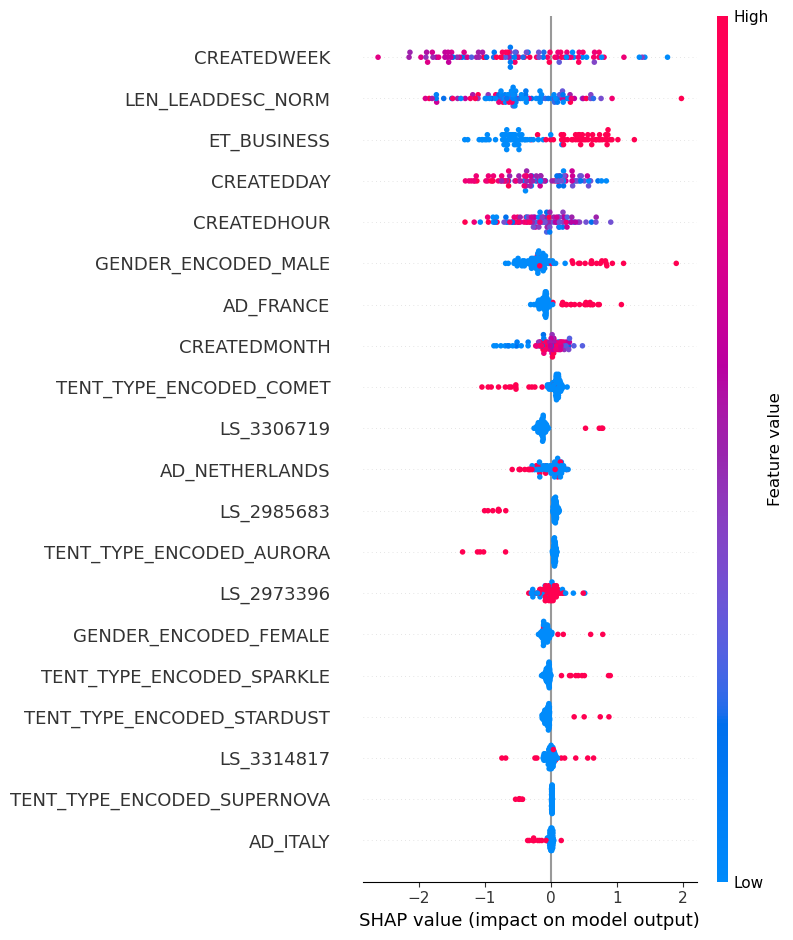

In [42]:
# Create a SHAP explainer object
explainer = shap.Explainer(xgb_classifier_)

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(leads_df_snowflake_test_pd[feature_columns])

# Summarize the effects of all the features
shap.summary_plot(shap_values, leads_df_snowflake_test_pd[feature_columns])


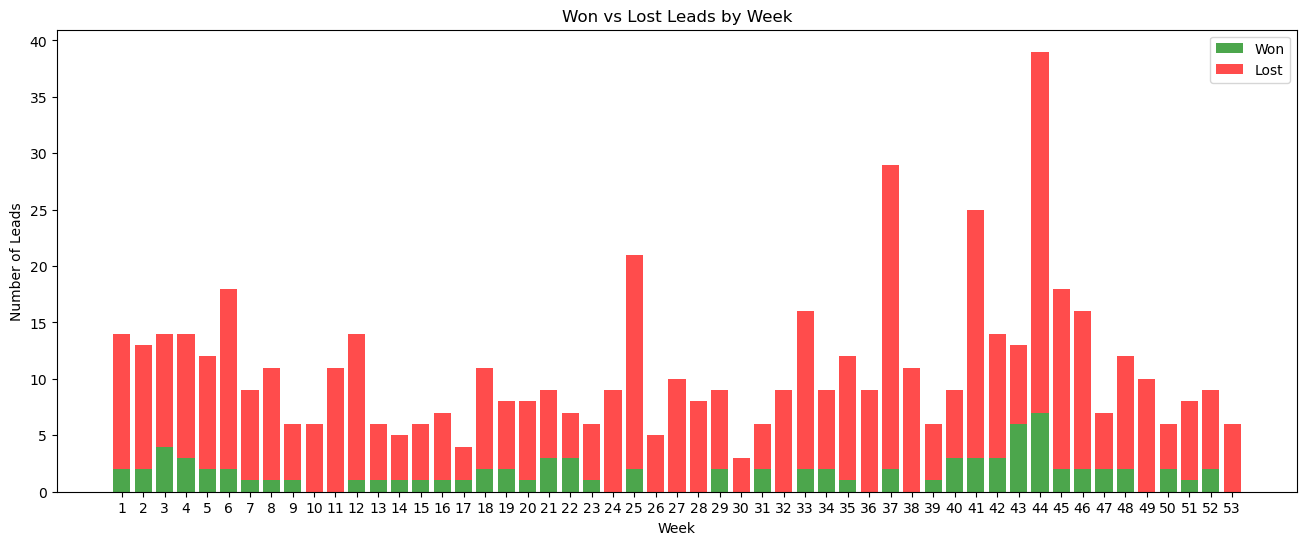

In [43]:
# Filter the DataFrame for 'Won' and 'Lost' leads
won_leads = leads_df[leads_df['O_OPPORTUNITYSTATE'] == 1]
lost_leads = leads_df[leads_df['O_OPPORTUNITYSTATE'] == 0]

won_leads = won_leads.to_pandas()
lost_leads = lost_leads.to_pandas()

# Assuming won_leads and lost_leads are pandas DataFrames with a column 'CREATEDWEEK'

# Calculate the count of won and lost leads for each week
week_counts_won = won_leads['CREATEDWEEK'].value_counts().sort_index()
week_counts_lost = lost_leads['CREATEDWEEK'].value_counts().sort_index()

# Ensure both series have the same weeks (in case some weeks are missing in either DataFrame)
all_weeks = week_counts_won.index.union(week_counts_lost.index)
week_counts_won = week_counts_won.reindex(all_weeks, fill_value=0)
week_counts_lost = week_counts_lost.reindex(all_weeks, fill_value=0)

# Create an array for the positions of the bars on the x-axis
x_pos = np.arange(len(all_weeks))
# Plotting the histogram
plt.figure(figsize=(16, 6))

# Plot the 'Won' category
plt.bar(x_pos, week_counts_won, align='center', alpha=0.7, color='green', label='Won')

# Plot the 'Lost' category on top of 'Won'
plt.bar(x_pos, week_counts_lost, bottom=week_counts_won, align='center', alpha=0.7, color='red', label='Lost')

# Add labels, title, and legend
plt.xlabel('Week')
plt.ylabel('Number of Leads')
plt.title('Won vs Lost Leads by Week')
plt.xticks(x_pos, all_weeks)
plt.legend()

# Show the plot
plt.show()



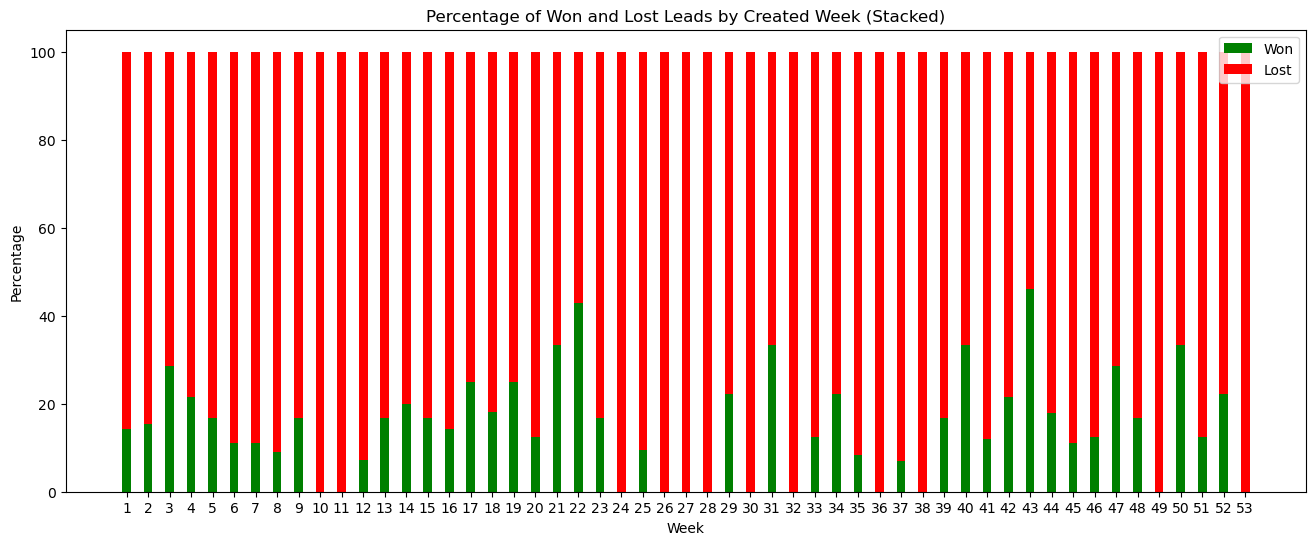

In [44]:
# Assuming 'won_leads' and 'lost_leads' are your datasets
# and 'CREATEDWEEK' is the feature you're interested in

# Define the bins for the histogram
bins = np.arange(1, 55, 1)  # for weeks, from 0 to 52

# Calculate histogram for Won and Lost leads
hist_won, _ = np.histogram(won_leads['CREATEDWEEK'], bins=bins)
hist_lost, _ = np.histogram(lost_leads['CREATEDWEEK'], bins=bins)

# Calculate the total leads for each bin
total_leads = hist_won + hist_lost

# Avoid division by zero
total_leads[total_leads == 0] = 1

# Calculate percentages
percent_won = (hist_won / total_leads) * 100
percent_lost = (hist_lost / total_leads) * 100

# Plotting
plt.figure(figsize=(16, 6))
plt.bar(bins[:-1], percent_won, width=0.4, label='Won', align='center', color='green')
plt.bar(bins[:-1], percent_lost, width=0.4, bottom=percent_won, label='Lost', align='center', color='red')
plt.xlabel('Week')
plt.ylabel('Percentage')
plt.title('Percentage of Won and Lost Leads by Created Week (Stacked)')
plt.legend()

# Set x-axis ticks to show every week
plt.xticks(bins[:-1])  # Set x-ticks to every week

plt.show()

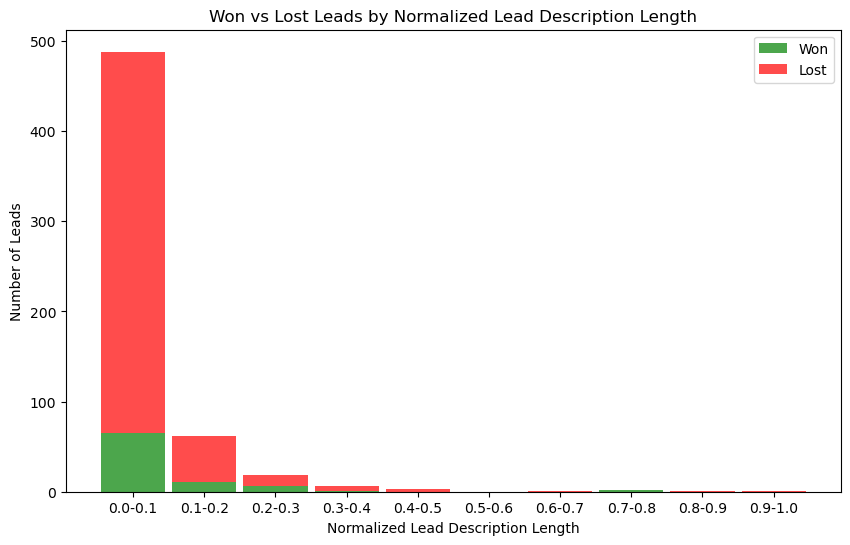

In [45]:
# Define the bin edges
bins = np.arange(0, 1.1, 0.1)  # Creates an array from 0 to 1 with a step of 0.1
# Filter the DataFrame for 'Won' and 'Lost' leads
won_leads = leads_df[leads_df['O_OPPORTUNITYSTATE'] == 1]
lost_leads = leads_df[leads_df['O_OPPORTUNITYSTATE'] == 0]

won_leads = won_leads.to_pandas()
lost_leads = lost_leads.to_pandas()

# Calculate the histogram data for won and lost leads
hist_won, _ = np.histogram(won_leads['LEN_LEADDESC_NORM'], bins=bins)
hist_lost, _ = np.histogram(lost_leads['LEN_LEADDESC_NORM'], bins=bins)

# Create an array for the positions of the bars on the x-axis
x_pos = (bins[:-1] + bins[1:]) / 2  # Midpoint of each bin

# Plotting the histogram
plt.figure(figsize=(10, 6))

# Plot the 'Won' category
plt.bar(x_pos, hist_won, width=0.09, align='center', alpha=0.7, color='green', label='Won')

# Plot the 'Lost' category on top of 'Won'
plt.bar(x_pos, hist_lost, width=0.09, bottom=hist_won, align='center', alpha=0.7, color='red', label='Lost')

# Add labels, title, and legend
plt.xlabel('Normalized Lead Description Length')
plt.ylabel('Number of Leads')
plt.title('Won vs Lost Leads by Normalized Lead Description Length')
plt.xticks(x_pos, labels=[f"{round(b, 1)}-{round(b+0.1, 1)}" for b in bins[:-1]])
plt.legend()

# Show the plot
plt.show()


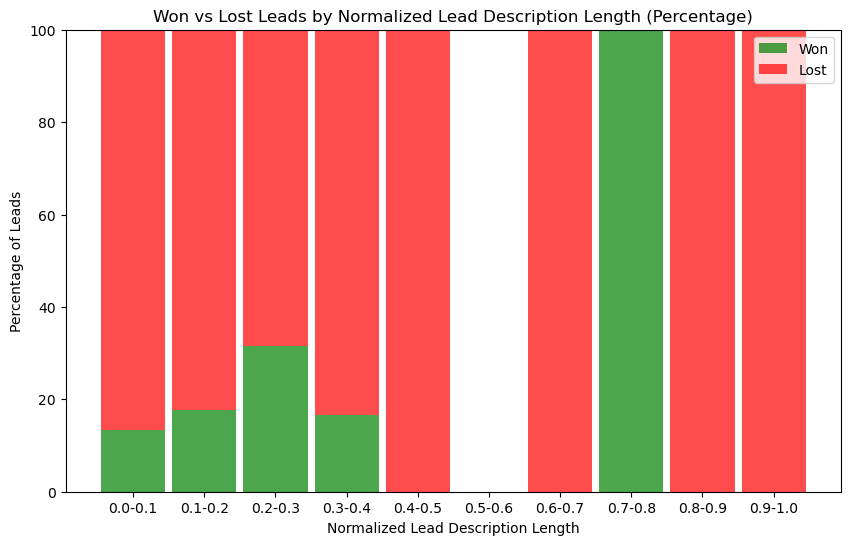

In [46]:
import matplotlib.pyplot as plt
import numpy as np

# Define the bin edges
bins = np.arange(0, 1.1, 0.1)  # Creates an array from 0 to 1 with a step of 0.1

# Filter the DataFrame for 'Won' and 'Lost' leads
won_leads = leads_df[leads_df['O_OPPORTUNITYSTATE'] == 1]
lost_leads = leads_df[leads_df['O_OPPORTUNITYSTATE'] == 0]

won_leads = won_leads.to_pandas()
lost_leads = lost_leads.to_pandas()

# Calculate the histogram data for won and lost leads
hist_won, _ = np.histogram(won_leads['LEN_LEADDESC_NORM'], bins=bins)
hist_lost, _ = np.histogram(lost_leads['LEN_LEADDESC_NORM'], bins=bins)

# Calculate the total leads for each bin
total_leads_per_bin = hist_won + hist_lost

# Calculate the percentage of won and lost leads for each bin
percentage_won = (hist_won / total_leads_per_bin) * 100
percentage_lost = (hist_lost / total_leads_per_bin) * 100

# Create an array for the positions of the bars on the x-axis
x_pos = (bins[:-1] + bins[1:]) / 2  # Midpoint of each bin

# Plotting the histogram
plt.figure(figsize=(10, 6))

# Plot the 'Won' category
plt.bar(x_pos, percentage_won, width=0.09, align='center', alpha=0.7, color='green', label='Won')

# Plot the 'Lost' category on top of 'Won'
plt.bar(x_pos, percentage_lost, width=0.09, bottom=percentage_won, align='center', alpha=0.7, color='red', label='Lost')

# Add labels, title, and legend
plt.xlabel('Normalized Lead Description Length')
plt.ylabel('Percentage of Leads')
plt.title('Won vs Lost Leads by Normalized Lead Description Length (Percentage)')
plt.xticks(x_pos, labels=[f"{round(b, 1)}-{round(b+0.1, 1)}" for b in bins[:-1]])
plt.legend()

# Show the plot
plt.show()

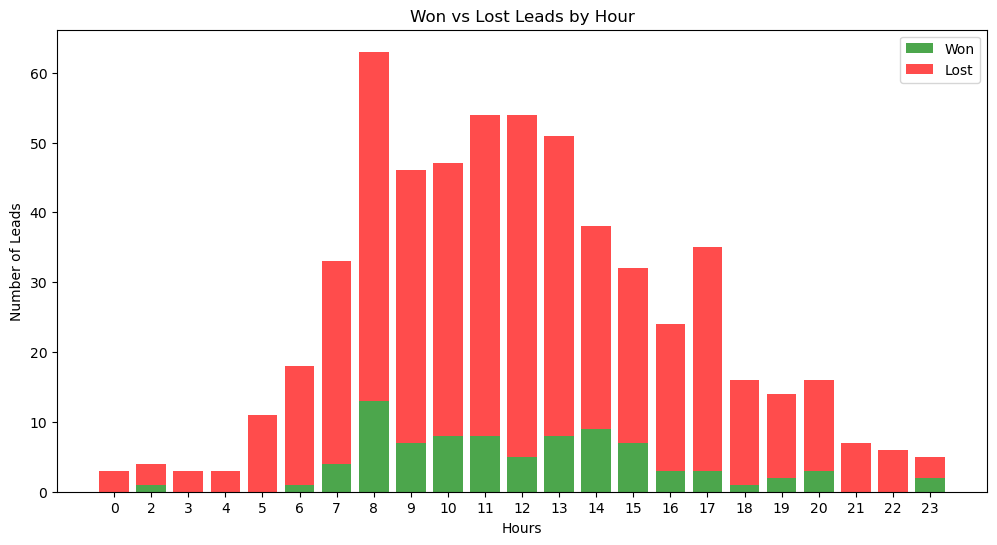

In [47]:
# Filter the DataFrame for 'Won' and 'Lost' leads
# won_leads = leads_df[leads_df['O_OPPORTUNITYSTATE'] == 1]
# lost_leads = leads_df[leads_df['O_OPPORTUNITYSTATE'] == 0]

# won_leads = won_leads.to_pandas()
# lost_leads = lost_leads.to_pandas()

# Assuming won_leads and lost_leads are pandas DataFrames with a column 'CREATEDHOUR'

# Calculate the count of won and lost leads for each week
hours_counts_won = won_leads['CREATEDHOUR'].value_counts().sort_index()
hours_counts_lost = lost_leads['CREATEDHOUR'].value_counts().sort_index()

# Ensure both series have the same weeks (in case some weeks are missing in either DataFrame)
all_hours = hours_counts_won.index.union(hours_counts_lost.index)
hours_counts_won = hours_counts_won.reindex(all_hours, fill_value=0)
hours_counts_lost = hours_counts_lost.reindex(all_hours, fill_value=0)

# Create an array for the positions of the bars on the x-axis
x_pos = np.arange(len(all_hours))
# Plotting the histogram
plt.figure(figsize=(12, 6))

# Plot the 'Won' category
plt.bar(x_pos, hours_counts_won, align='center', alpha=0.7, color='green', label='Won')

# Plot the 'Lost' category on top of 'Won'
plt.bar(x_pos, hours_counts_lost, bottom=hours_counts_won, align='center', alpha=0.7, color='red', label='Lost')

# Add labels, title, and legend
plt.xlabel('Hours')
plt.ylabel('Number of Leads')
plt.title('Won vs Lost Leads by Hour')
plt.xticks(x_pos, all_hours)
plt.legend()

# Show the plot
plt.show()

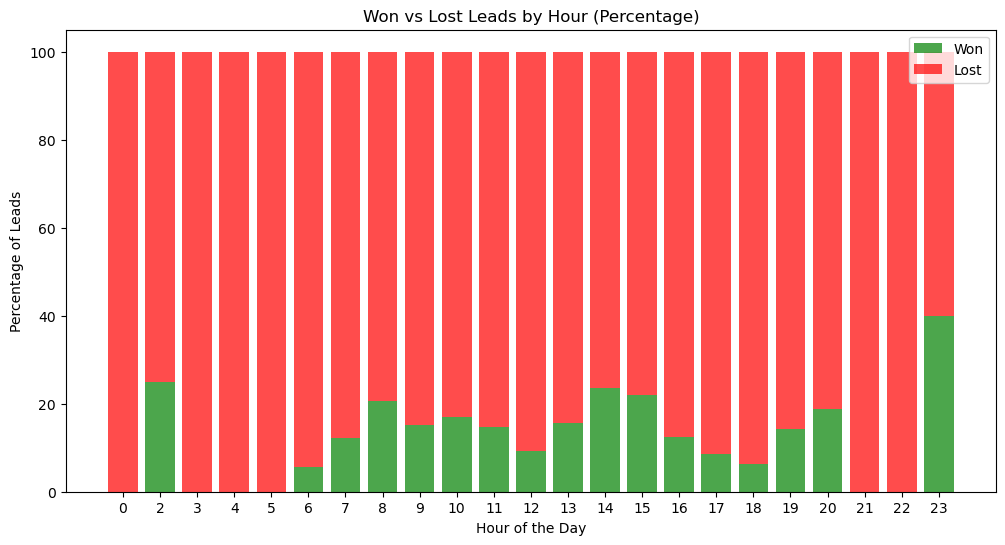

In [48]:
import matplotlib.pyplot as plt
import numpy as np

# Filter the DataFrame for 'Won' and 'Lost' leads
# won_leads = leads_df_snowflake[leads_df_snowflake['O_OPPORTUNITYSTATE'] == 1]
# lost_leads = leads_df_snowflake[leads_df_snowflake['O_OPPORTUNITYSTATE'] == 0]

# won_leads = won_leads.to_pandas()
# lost_leads = lost_leads.to_pandas()

# Calculate the count of won and lost leads for each hour
hours_counts_won = won_leads['CREATEDHOUR'].value_counts().sort_index()
hours_counts_lost = lost_leads['CREATEDHOUR'].value_counts().sort_index()

# Ensure both series have the same hours (in case some hours are missing in either DataFrame)
all_hours = hours_counts_won.index.union(hours_counts_lost.index)
hours_counts_won = hours_counts_won.reindex(all_hours, fill_value=0)
hours_counts_lost = hours_counts_lost.reindex(all_hours, fill_value=0)

# Calculate the total leads for each hour
total_leads_per_hour = hours_counts_won + hours_counts_lost

# Calculate the percentage of won and lost leads for each hour
percentage_won = (hours_counts_won / total_leads_per_hour) * 100
percentage_lost = (hours_counts_lost / total_leads_per_hour) * 100

# Create an array for the positions of the bars on the x-axis
x_pos = np.arange(len(all_hours))

# Plotting the histogram
plt.figure(figsize=(12, 6))

# Plot the 'Won' category
plt.bar(x_pos, percentage_won, align='center', alpha=0.7, color='green', label='Won')

# Plot the 'Lost' category on top of 'Won'
plt.bar(x_pos, percentage_lost, align='center', alpha=0.7, color='red', bottom=percentage_won, label='Lost')

# Add labels, title, and legend
plt.xlabel('Hour of the Day')
plt.ylabel('Percentage of Leads')
plt.title('Won vs Lost Leads by Hour (Percentage)')
plt.xticks(x_pos, all_hours)
plt.legend()

# Show the plot
plt.show()


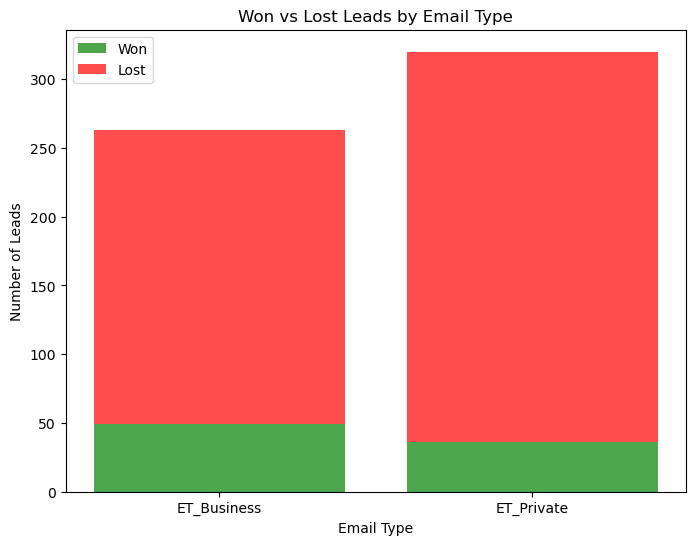

In [49]:
import matplotlib.pyplot as plt
import numpy as np

# Filter the DataFrame for 'Won' and 'Lost' leads
# won_leads = leads_df_snowflake[leads_df_snowflake['O_OPPORTUNITYSTATE'] == 1]
# lost_leads = leads_df_snowflake[leads_df_snowflake['O_OPPORTUNITYSTATE'] == 0]

# won_leads = won_leads.to_pandas()
# lost_leads = lost_leads.to_pandas()

# Calculate the count of won and lost leads for each email type
won_business = won_leads[won_leads['ET_BUSINESS'] == 1].shape[0]
lost_business = lost_leads[lost_leads['ET_BUSINESS'] == 1].shape[0]

won_private = won_leads[won_leads['ET_PRIVATE'] == 1].shape[0]
lost_private = lost_leads[lost_leads['ET_PRIVATE'] == 1].shape[0]

# Create an array for the positions of the bars on the x-axis
x_pos = np.arange(2)

# Plotting the histogram
plt.figure(figsize=(8, 6))

# Plot the 'Won' category for Business and Private
plt.bar(x_pos, [won_business, won_private], align='center', alpha=0.7, color='green', label='Won')

# Plot the 'Lost' category on top of 'Won' for Business and Private
plt.bar(x_pos, [lost_business, lost_private], bottom=[won_business, won_private], align='center', alpha=0.7, color='red', label='Lost')

# Add labels, title, and legend
plt.xlabel('Email Type')
plt.ylabel('Number of Leads')
plt.title('Won vs Lost Leads by Email Type')
plt.xticks(x_pos, ['ET_Business', 'ET_Private'])
plt.legend()

# Show the plot
plt.show()


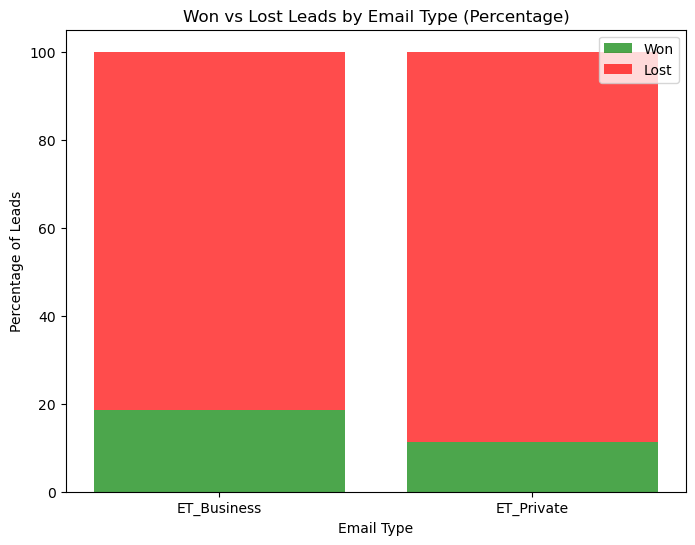

In [50]:
import matplotlib.pyplot as plt
import numpy as np

# Filter the DataFrame for 'Won' and 'Lost' leads
# won_leads = leads_df_snowflake[leads_df_snowflake['O_OPPORTUNITYSTATE'] == 1]
# lost_leads = leads_df_snowflake[leads_df_snowflake['O_OPPORTUNITYSTATE'] == 0]

# won_leads = won_leads.to_pandas()
# lost_leads = lost_leads.to_pandas()

# Calculate the count of won and lost leads for each email type
won_business = won_leads[won_leads['ET_BUSINESS'] == 1].shape[0]
lost_business = lost_leads[lost_leads['ET_BUSINESS'] == 1].shape[0]

won_private = won_leads[won_leads['ET_PRIVATE'] == 1].shape[0]
lost_private = lost_leads[lost_leads['ET_PRIVATE'] == 1].shape[0]

# Calculate the total leads for each email type
total_business = won_business + lost_business
total_private = won_private + lost_private

# Calculate the percentages
percent_won_business = (won_business / total_business) * 100 if total_business > 0 else 0
percent_lost_business = (lost_business / total_business) * 100 if total_business > 0 else 0

percent_won_private = (won_private / total_private) * 100 if total_private > 0 else 0
percent_lost_private = (lost_private / total_private) * 100 if total_private > 0 else 0

# Create an array for the positions of the bars on the x-axis
x_pos = np.arange(2)

# Plotting the histogram
plt.figure(figsize=(8, 6))

# Plot the 'Won' percentage for Business and Private
plt.bar(x_pos, [percent_won_business, percent_won_private], align='center', alpha=0.7, color='green', label='Won')

# Plot the 'Lost' percentage on top of 'Won' for Business and Private
plt.bar(x_pos, [percent_lost_business, percent_lost_private], bottom=[percent_won_business, percent_won_private], align='center', alpha=0.7, color='red', label='Lost')

# Add labels, title, and legend
plt.xlabel('Email Type')
plt.ylabel('Percentage of Leads')
plt.title('Won vs Lost Leads by Email Type (Percentage)')
plt.xticks(x_pos, ['ET_Business', 'ET_Private'])
plt.legend()

# Show the plot
plt.show()


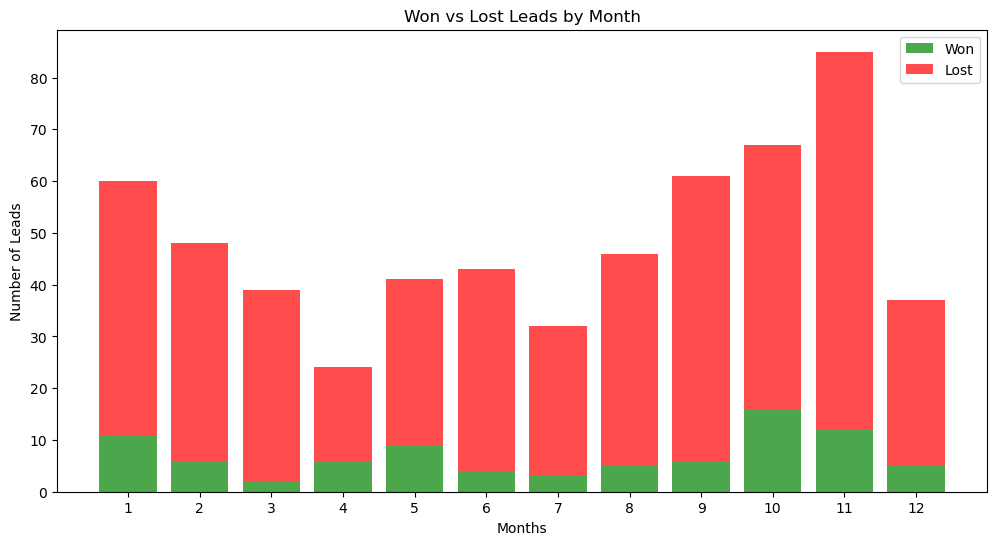

In [51]:
# Filter the DataFrame for 'Won' and 'Lost' leads
# won_leads = leads_df_snowflake[leads_df_snowflake['O_OPPORTUNITYSTATE'] == 1]
# lost_leads = leads_df_snowflake[leads_df_snowflake['O_OPPORTUNITYSTATE'] == 0]

# won_leads = won_leads.to_pandas()
# lost_leads = lost_leads.to_pandas()

# Assuming won_leads and lost_leads are pandas DataFrames with a column 'CREATEDHOUR'

# Calculate the count of won and lost leads for each week
months_counts_won = won_leads['CREATEDMONTH'].value_counts().sort_index()
months_counts_lost = lost_leads['CREATEDMONTH'].value_counts().sort_index()

# Ensure both series have the same weeks (in case some weeks are missing in either DataFrame)
all_months = months_counts_won.index.union(months_counts_lost.index)
months_counts_won = months_counts_won.reindex(all_months, fill_value=0)
months_counts_lost = months_counts_lost.reindex(all_months, fill_value=0)

# Create an array for the positions of the bars on the x-axis
x_pos = np.arange(len(all_months))
# Plotting the histogram
plt.figure(figsize=(12, 6))

# Plot the 'Won' category
plt.bar(x_pos, months_counts_won, align='center', alpha=0.7, color='green', label='Won')

# Plot the 'Lost' category on top of 'Won'
plt.bar(x_pos, months_counts_lost, bottom=months_counts_won, align='center', alpha=0.7, color='red', label='Lost')

# Add labels, title, and legend
plt.xlabel('Months')
plt.ylabel('Number of Leads')
plt.title('Won vs Lost Leads by Month')
plt.xticks(x_pos, all_months)
plt.legend()

# Show the plot
plt.show()

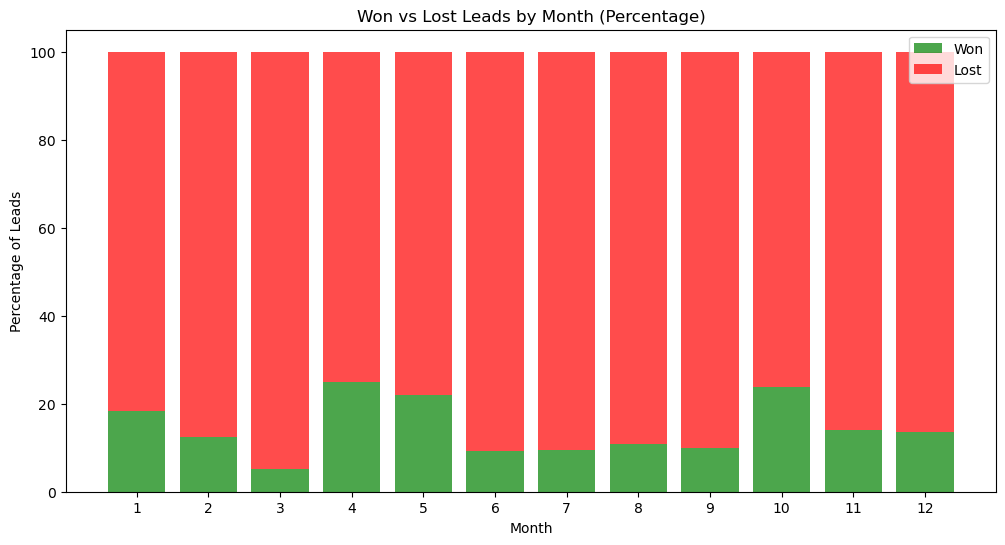

In [52]:
import matplotlib.pyplot as plt
import numpy as np

# Filter the DataFrame for 'Won' and 'Lost' leads
# won_leads = leads_df_snowflake[leads_df_snowflake['O_OPPORTUNITYSTATE'] == 1]
# lost_leads = leads_df_snowflake[leads_df_snowflake['O_OPPORTUNITYSTATE'] == 0]

# won_leads = won_leads.to_pandas()
# lost_leads = lost_leads.to_pandas()

# Calculate the count of won and lost leads for each month
months_counts_won = won_leads['CREATEDMONTH'].value_counts().sort_index()
months_counts_lost = lost_leads['CREATEDMONTH'].value_counts().sort_index()

# Ensure both series have the same months
all_months = months_counts_won.index.union(months_counts_lost.index)
months_counts_won = months_counts_won.reindex(all_months, fill_value=0)
months_counts_lost = months_counts_lost.reindex(all_months, fill_value=0)

# Calculate the total leads for each month
total_leads_per_month = months_counts_won + months_counts_lost

# Calculate the percentages
percent_won = (months_counts_won / total_leads_per_month) * 100
percent_lost = (months_counts_lost / total_leads_per_month) * 100

# Create an array for the positions of the bars on the x-axis
x_pos = np.arange(len(all_months))

# Plotting the histogram
plt.figure(figsize=(12, 6))

# Plot the 'Won' percentage for each month
plt.bar(x_pos, percent_won, align='center', alpha=0.7, color='green', label='Won')

# Plot the 'Lost' percentage on top of 'Won' for each month
plt.bar(x_pos, percent_lost, bottom=percent_won, align='center', alpha=0.7, color='red', label='Lost')

# Add labels, title, and legend
plt.xlabel('Month')
plt.ylabel('Percentage of Leads')
plt.title('Won vs Lost Leads by Month (Percentage)')
plt.xticks(x_pos, all_months)
plt.legend()

# Show the plot
plt.show()


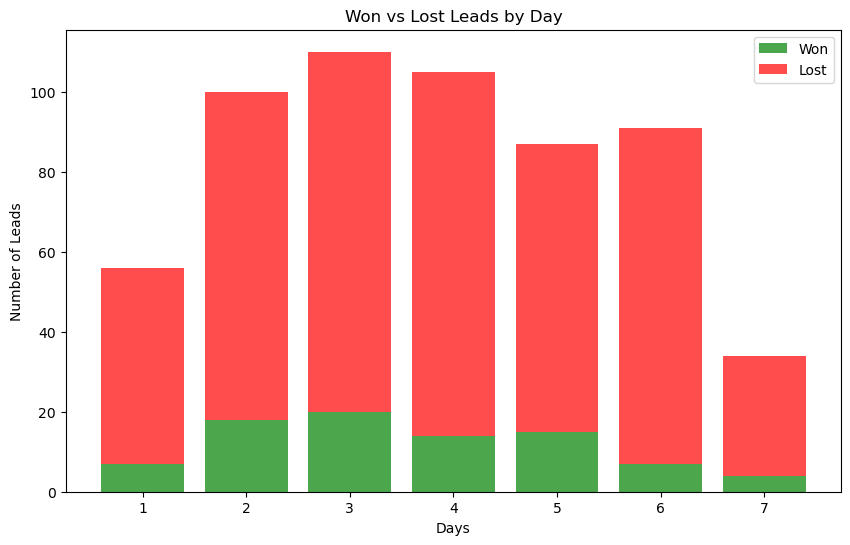

In [53]:
# Filter the DataFrame for 'Won' and 'Lost' leads
# won_leads = leads_df_snowflake[leads_df_snowflake['O_OPPORTUNITYSTATE'] == 1]
# lost_leads = leads_df_snowflake[leads_df_snowflake['O_OPPORTUNITYSTATE'] == 0]

# won_leads = won_leads.to_pandas()
# lost_leads = lost_leads.to_pandas()

# Assuming won_leads and lost_leads are pandas DataFrames with a column 'CREATEDHOUR'

# Calculate the count of won and lost leads for each week
days_counts_won = won_leads['CREATEDDAY'].value_counts().sort_index()
days_counts_lost = lost_leads['CREATEDDAY'].value_counts().sort_index()

# Ensure both series have the same weeks (in case some weeks are missing in either DataFrame)
all_days = days_counts_won.index.union(days_counts_lost.index)
days_counts_won = days_counts_won.reindex(all_days, fill_value=0)
days_counts_lost = days_counts_lost.reindex(all_days, fill_value=0)

# Create an array for the positions of the bars on the x-axis
x_pos = np.arange(len(all_days))
# Plotting the histogram
plt.figure(figsize=(10, 6))

# Plot the 'Won' category
plt.bar(x_pos, days_counts_won, align='center', alpha=0.7, color='green', label='Won')

# Plot the 'Lost' category on top of 'Won'
plt.bar(x_pos, days_counts_lost, bottom=days_counts_won, align='center', alpha=0.7, color='red', label='Lost')

# Add labels, title, and legend
plt.xlabel('Days')
plt.ylabel('Number of Leads')
plt.title('Won vs Lost Leads by Day')
plt.xticks(x_pos, all_days)
plt.legend()

# Show the plot
plt.show()

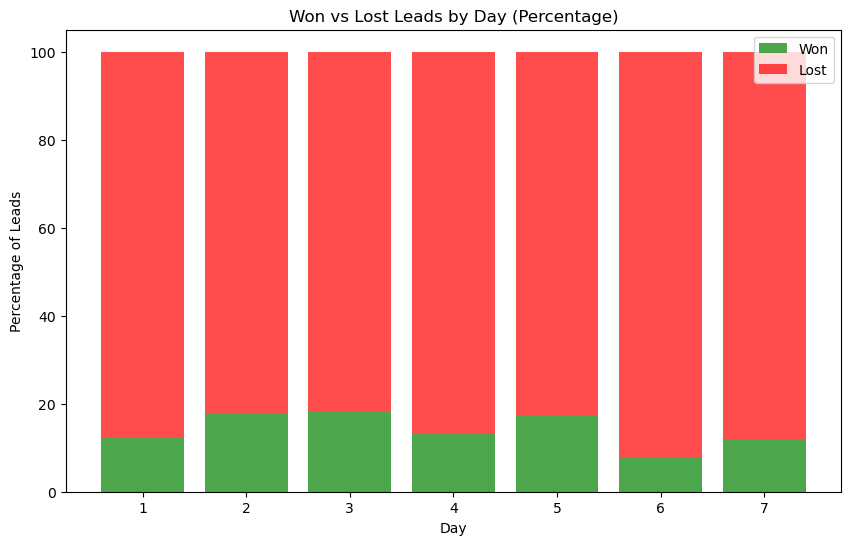

In [54]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming won_leads and lost_leads are pandas DataFrames with a column 'CREATEDDAY'

# Calculate the count of won and lost leads for each day
days_counts_won = won_leads['CREATEDDAY'].value_counts().sort_index()
days_counts_lost = lost_leads['CREATEDDAY'].value_counts().sort_index()

# Ensure both series have the same days
all_days = days_counts_won.index.union(days_counts_lost.index)
days_counts_won = days_counts_won.reindex(all_days, fill_value=0)
days_counts_lost = days_counts_lost.reindex(all_days, fill_value=0)

# Calculate the total leads for each day
total_leads_per_day = days_counts_won + days_counts_lost

# Calculate the percentage of won and lost leads for each day
percentage_won = (days_counts_won / total_leads_per_day) * 100
percentage_lost = (days_counts_lost / total_leads_per_day) * 100

# Create an array for the positions of the bars on the x-axis
x_pos = np.arange(len(all_days))

# Plotting the histogram
plt.figure(figsize=(10, 6))

# Plot the 'Won' category
plt.bar(x_pos, percentage_won, align='center', alpha=0.7, color='green', label='Won')

# Plot the 'Lost' category on top of 'Won'
plt.bar(x_pos, percentage_lost, bottom=percentage_won, align='center', alpha=0.7, color='red', label='Lost')

# Add labels, title, and legend
plt.xlabel('Day')
plt.ylabel('Percentage of Leads')
plt.title('Won vs Lost Leads by Day (Percentage)')
plt.xticks(x_pos, all_days)
plt.legend()

# Show the plot
plt.show()


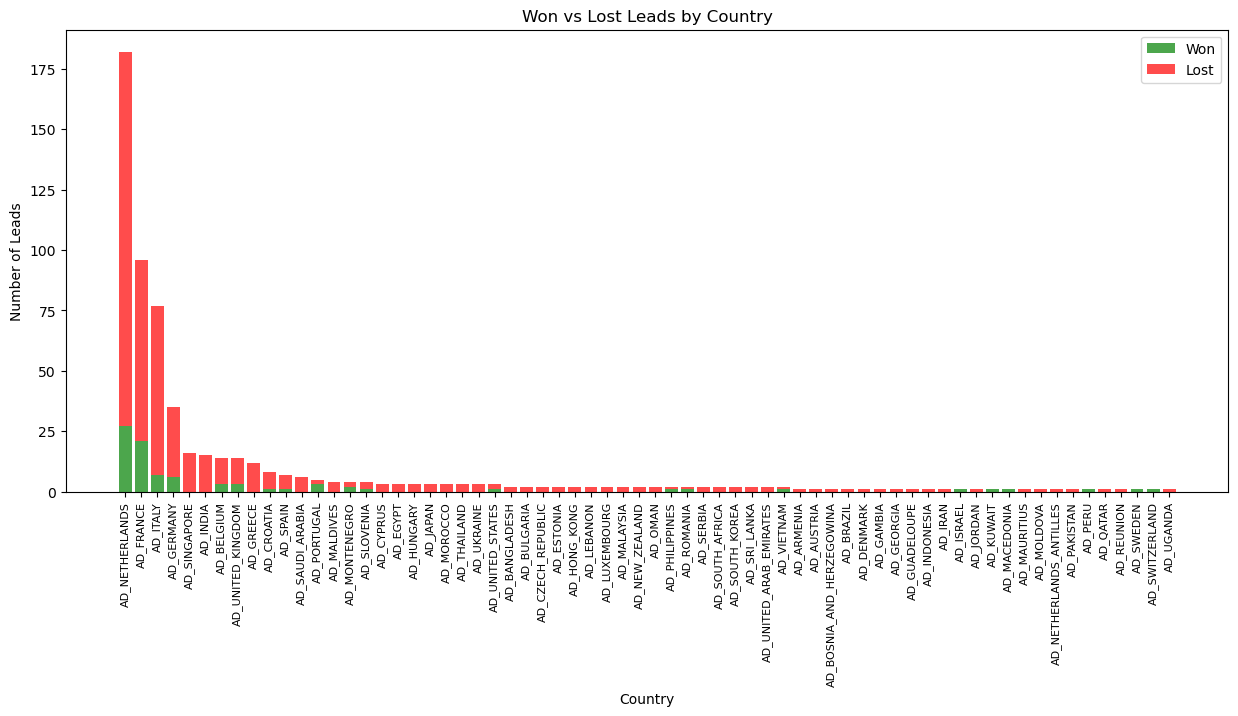

In [55]:
import matplotlib.pyplot as plt
import numpy as np

# Retrieve the columns containing the country values
country_columns = [col for col in leads_df.columns if col.startswith(('AD_'))]
country_columns = [col.replace('"', '') for col in country_columns]

# Initialize dictionaries to store the counts
won_counts = {country: won_leads[country].sum() for country in country_columns}
lost_counts = {country: lost_leads[country].sum() for country in country_columns}

# Calculate total leads per country and sort countries by total leads in descending order
total_leads = {country: won_counts[country] + lost_counts[country] for country in country_columns}
sorted_countries = sorted(total_leads, key=total_leads.get, reverse=True)

# Update the counts based on the sorted order
won_values = [won_counts[country] for country in sorted_countries]
lost_values = [lost_counts[country] for country in sorted_countries]

# Create an array for the positions of the bars on the x-axis
x_pos = np.arange(len(sorted_countries))

# Plotting the histogram
plt.figure(figsize=(15, 6))

# Plot the 'Won' category for each country
plt.bar(x_pos, won_values, align='center', alpha=0.7, color='green', label='Won')

# Plot the 'Lost' category on top of 'Won' for each country
plt.bar(x_pos, lost_values, bottom=won_values, align='center', alpha=0.7, color='red', label='Lost')

# Add labels, title, and legend
plt.xlabel('Country')
plt.ylabel('Number of Leads')
plt.title('Won vs Lost Leads by Country')
plt.xticks(x_pos, sorted_countries, rotation='vertical', fontsize=8)
plt.legend()

# Show the plot
plt.show()

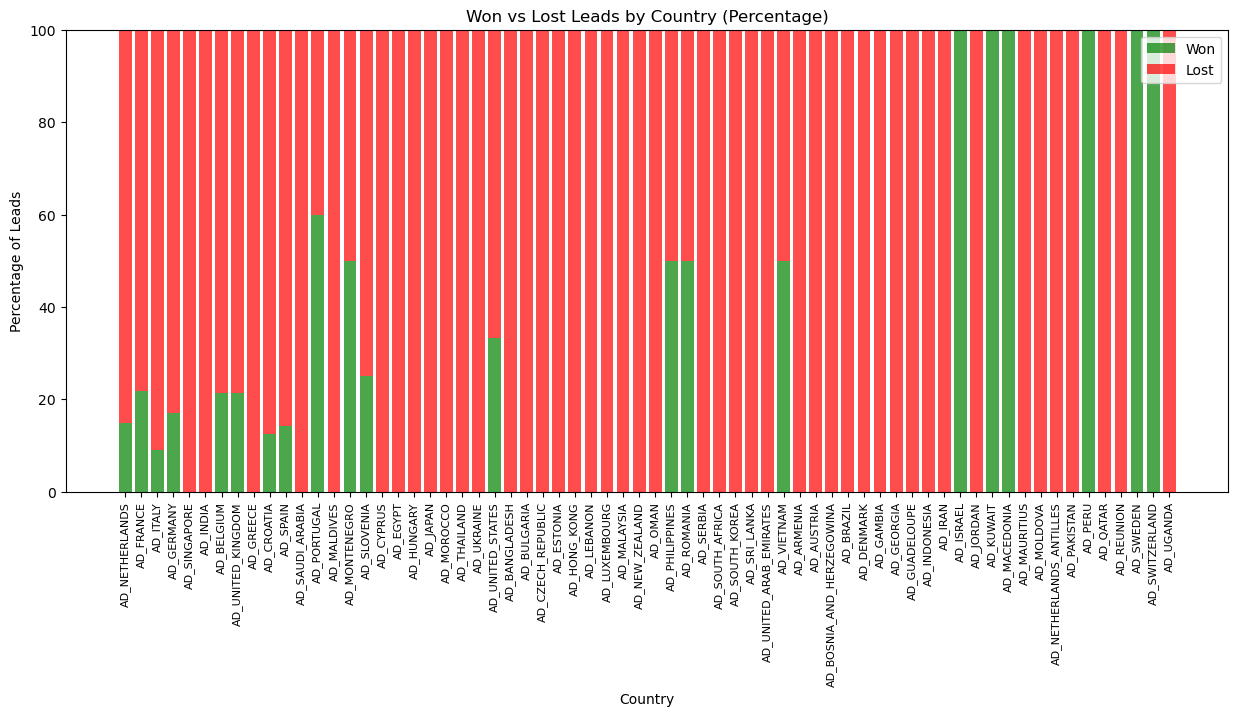

In [56]:
import matplotlib.pyplot as plt
import numpy as np

# Filter the DataFrame for 'Won' and 'Lost' leads
# won_leads = leads_df_snowflake[leads_df_snowflake['O_OPPORTUNITYSTATE'] == 1]
# lost_leads = leads_df_snowflake[leads_df_snowflake['O_OPPORTUNITYSTATE'] == 0]

# won_leads = won_leads.to_pandas()
# lost_leads = lost_leads.to_pandas()

# Retrieve the columns containing the country values
country_columns = [col for col in leads_df.columns if col.startswith(('AD_'))]
country_columns = [col.replace('"', '') for col in country_columns]

# Initialize dictionaries to store the counts
won_counts = {country: won_leads[country].sum() for country in country_columns}
lost_counts = {country: lost_leads[country].sum() for country in country_columns}

# Calculate total leads per country and sort countries by total leads in descending order
total_leads = {country: won_counts[country] + lost_counts[country] for country in country_columns}
sorted_countries = sorted(total_leads, key=total_leads.get, reverse=True)

# Calculate the percentage of won and lost leads for each country
won_percentages = [won_counts[country] / total_leads[country] * 100 if total_leads[country] > 0 else 0 for country in sorted_countries]
lost_percentages = [lost_counts[country] / total_leads[country] * 100 if total_leads[country] > 0 else 0 for country in sorted_countries]

# Create an array for the positions of the bars on the x-axis
x_pos = np.arange(len(sorted_countries))

# Plotting the histogram
plt.figure(figsize=(15, 6))

# Plot the 'Won' percentage for each country
plt.bar(x_pos, won_percentages, align='center', alpha=0.7, color='green', label='Won')

# Plot the 'Lost' percentage on top of 'Won' for each country
plt.bar(x_pos, lost_percentages, bottom=won_percentages, align='center', alpha=0.7, color='red', label='Lost')

# Add labels, title, and legend
plt.xlabel('Country')
plt.ylabel('Percentage of Leads')
plt.title('Won vs Lost Leads by Country (Percentage)')
plt.xticks(x_pos, sorted_countries, rotation='vertical', fontsize=8)
plt.legend()

# Show the plot
plt.show()


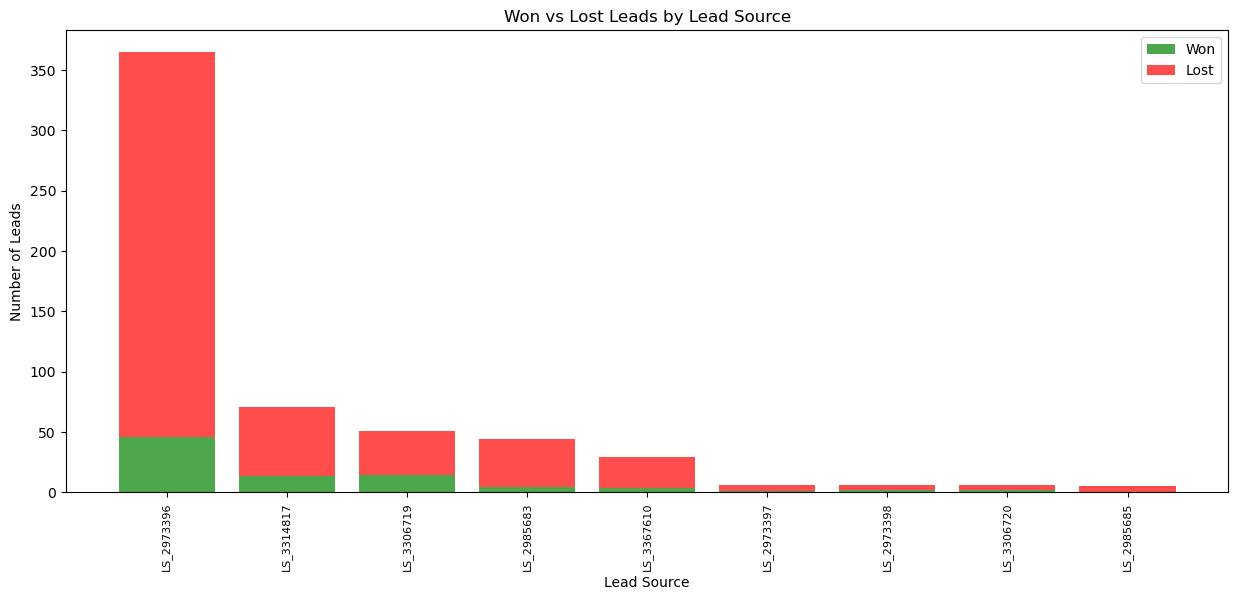

In [58]:
import matplotlib.pyplot as plt
import numpy as np

# Filter the DataFrame for 'Won' and 'Lost' leads
# won_leads = leads_df_snowflake[leads_df_snowflake['O_OPPORTUNITYSTATE'] == 1]
# lost_leads = leads_df_snowflake[leads_df_snowflake['O_OPPORTUNITYSTATE'] == 0]

# won_leads = won_leads.to_pandas()
# lost_leads = lost_leads.to_pandas()

# Retrieve the columns containing the lead source values
leadsource_columns = [col for col in leads_df.columns if col.startswith(('LS_'))]

# Initialize dictionaries to store the counts
won_counts = {leadsource: won_leads[leadsource].sum() for leadsource in leadsource_columns}
lost_counts = {leadsource: lost_leads[leadsource].sum() for leadsource in leadsource_columns}

# Calculate total leads per lead source and sort lead sources by total leads in descending order
total_leads = {leadsource: won_counts[leadsource] + lost_counts[leadsource] for leadsource in leadsource_columns}
sorted_lead_sources = sorted(total_leads, key=total_leads.get, reverse=True)

# Extract the counts for plotting
won_values = [won_counts[leadsource] for leadsource in sorted_lead_sources]
lost_values = [lost_counts[leadsource] for leadsource in sorted_lead_sources]

# Create an array for the positions of the bars on the x-axis
x_pos = np.arange(len(sorted_lead_sources))

# Plotting the histogram
plt.figure(figsize=(15, 6))

# Plot the 'Won' category for each lead source
plt.bar(x_pos, won_values, align='center', alpha=0.7, color='green', label='Won')

# Plot the 'Lost' category on top of 'Won' for each lead source
plt.bar(x_pos, lost_values, bottom=won_values, align='center', alpha=0.7, color='red', label='Lost')

# Add labels, title, and legend
plt.xlabel('Lead Source')
plt.ylabel('Number of Leads')
plt.title('Won vs Lost Leads by Lead Source')
plt.xticks(x_pos, sorted_lead_sources, rotation='vertical', fontsize=8)
plt.legend()

# Show the plot
plt.show()


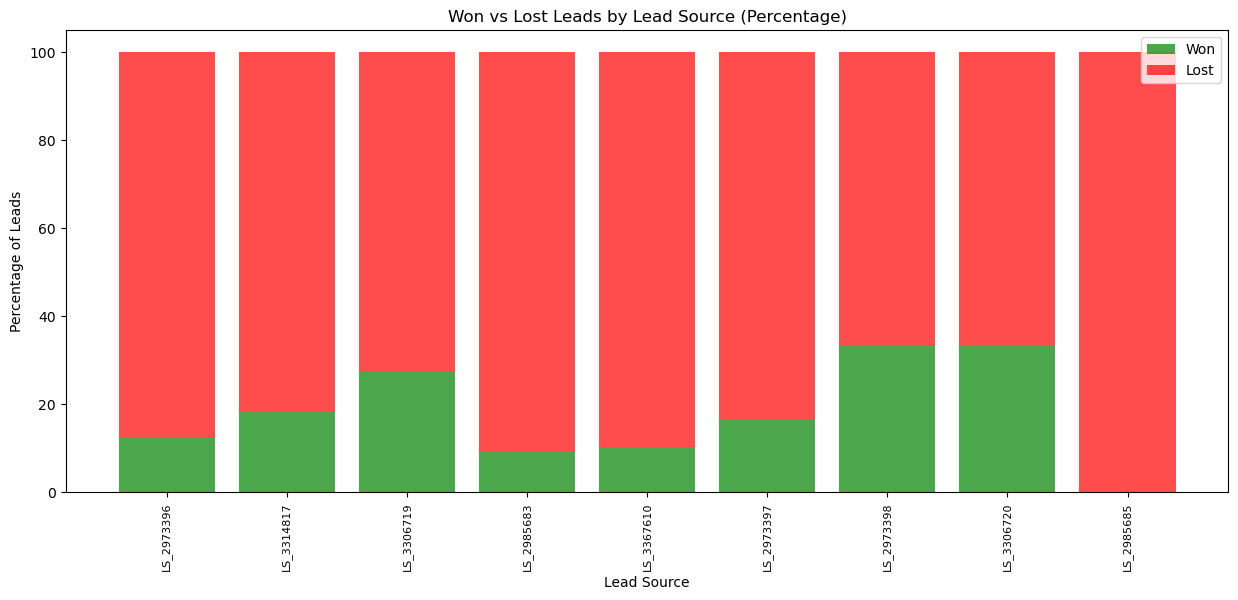

In [59]:
import matplotlib.pyplot as plt
import numpy as np

# # Filter the DataFrame for 'Won' and 'Lost' leads
# won_leads = leads_df_snowflake[leads_df_snowflake['O_OPPORTUNITYSTATE'] == 1]
# lost_leads = leads_df_snowflake[leads_df_snowflake['O_OPPORTUNITYSTATE'] == 0]

# won_leads = won_leads.to_pandas()
# lost_leads = lost_leads.to_pandas()

# Retrieve the columns containing the lead source values
leadsource_columns = [col for col in leads_df.columns if col.startswith(('LS_'))]

# Initialize dictionaries to store the counts and percentages
won_counts = {leadsource: won_leads[leadsource].sum() for leadsource in leadsource_columns}
lost_counts = {leadsource: lost_leads[leadsource].sum() for leadsource in leadsource_columns}

# Calculate total leads per lead source and sort lead sources by total leads in descending order
total_leads = {leadsource: won_counts[leadsource] + lost_counts[leadsource] for leadsource in leadsource_columns}
sorted_lead_sources = sorted(total_leads, key=total_leads.get, reverse=True)

# Calculate the percentage of won and lost leads for each lead source
won_percentages = [won_counts[leadsource] / total_leads[leadsource] * 100 if total_leads[leadsource] > 0 else 0 for leadsource in sorted_lead_sources]
lost_percentages = [lost_counts[leadsource] / total_leads[leadsource] * 100 if total_leads[leadsource] > 0 else 0 for leadsource in sorted_lead_sources]

# Create an array for the positions of the bars on the x-axis
x_pos = np.arange(len(sorted_lead_sources))

# Plotting the histogram
plt.figure(figsize=(15, 6))

# Plot the 'Won' percentage for each lead source
plt.bar(x_pos, won_percentages, align='center', alpha=0.7, color='green', label='Won')

# Plot the 'Lost' percentage on top of 'Won' for each lead source
plt.bar(x_pos, lost_percentages, bottom=won_percentages, align='center', alpha=0.7, color='red', label='Lost')

# Add labels, title, and legend
plt.xlabel('Lead Source')
plt.ylabel('Percentage of Leads')
plt.title('Won vs Lost Leads by Lead Source (Percentage)')
plt.xticks(x_pos, sorted_lead_sources, rotation='vertical', fontsize=8)
plt.legend()

# Show the plot
plt.show()


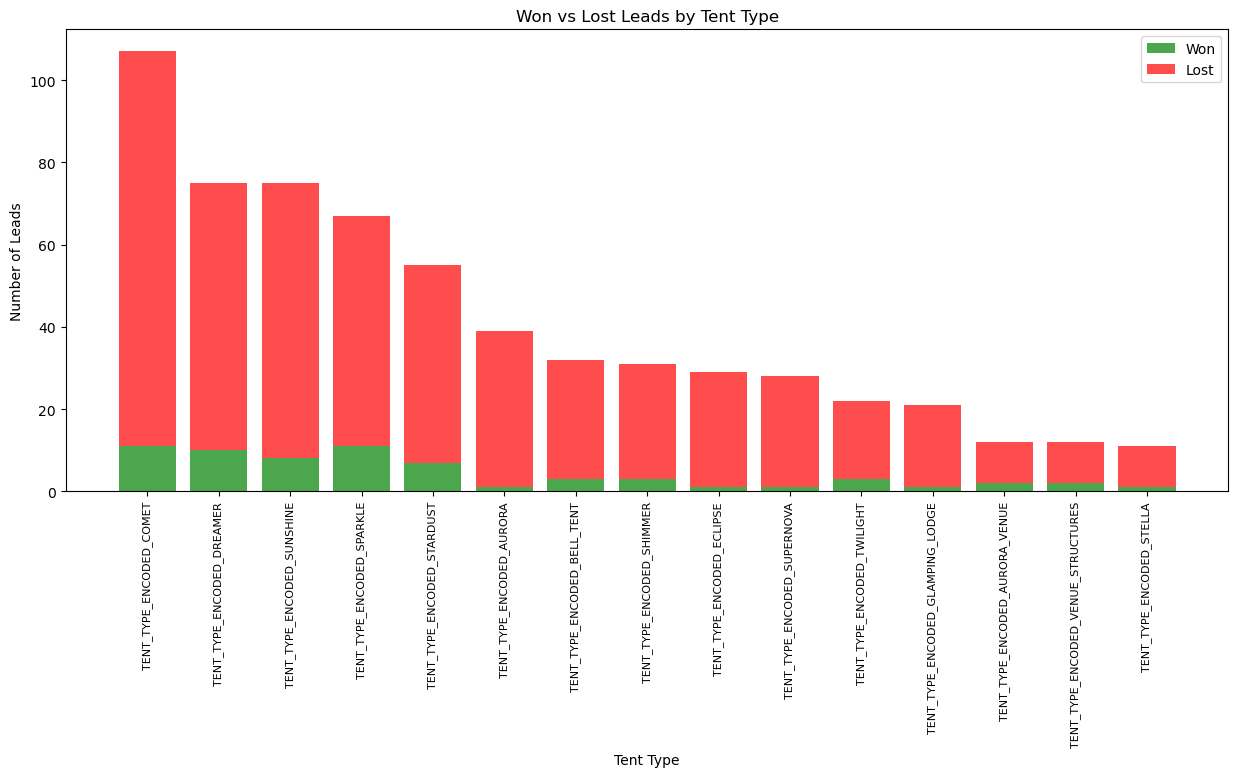

In [60]:
import matplotlib.pyplot as plt
import numpy as np

# Retrieve the columns containing the tent type values
tent_type_columns = [col for col in leads_df.columns if col.startswith('TENT_TYPE_ENCODED_')]
tent_type_columns = [col.replace('"', '') for col in tent_type_columns]

# Initialize dictionaries to store the counts
won_counts = {tent_type: won_leads[tent_type].sum() for tent_type in tent_type_columns}
lost_counts = {tent_type: lost_leads[tent_type].sum() for tent_type in tent_type_columns}

# Calculate total leads per tent type and sort tent types by total leads in descending order
total_leads = {tent_type: won_counts[tent_type] + lost_counts[tent_type] for tent_type in tent_type_columns}
sorted_tent_types = sorted(total_leads, key=total_leads.get, reverse=True)

# Update the counts based on the sorted order
won_values = [won_counts[tent_type] for tent_type in sorted_tent_types]
lost_values = [lost_counts[tent_type] for tent_type in sorted_tent_types]

# Create an array for the positions of the bars on the x-axis
x_pos = np.arange(len(sorted_tent_types))

# Plotting the histogram
plt.figure(figsize=(15, 6))

# Plot the 'Won' category for each tent type
plt.bar(x_pos, won_values, align='center', alpha=0.7, color='green', label='Won')

# Plot the 'Lost' category on top of 'Won' for each tent type
plt.bar(x_pos, lost_values, bottom=won_values, align='center', alpha=0.7, color='red', label='Lost')

# Add labels, title, and legend
plt.xlabel('Tent Type')
plt.ylabel('Number of Leads')
plt.title('Won vs Lost Leads by Tent Type')
plt.xticks(x_pos, sorted_tent_types, rotation='vertical', fontsize=8)
plt.legend()

# Show the plot
plt.show()


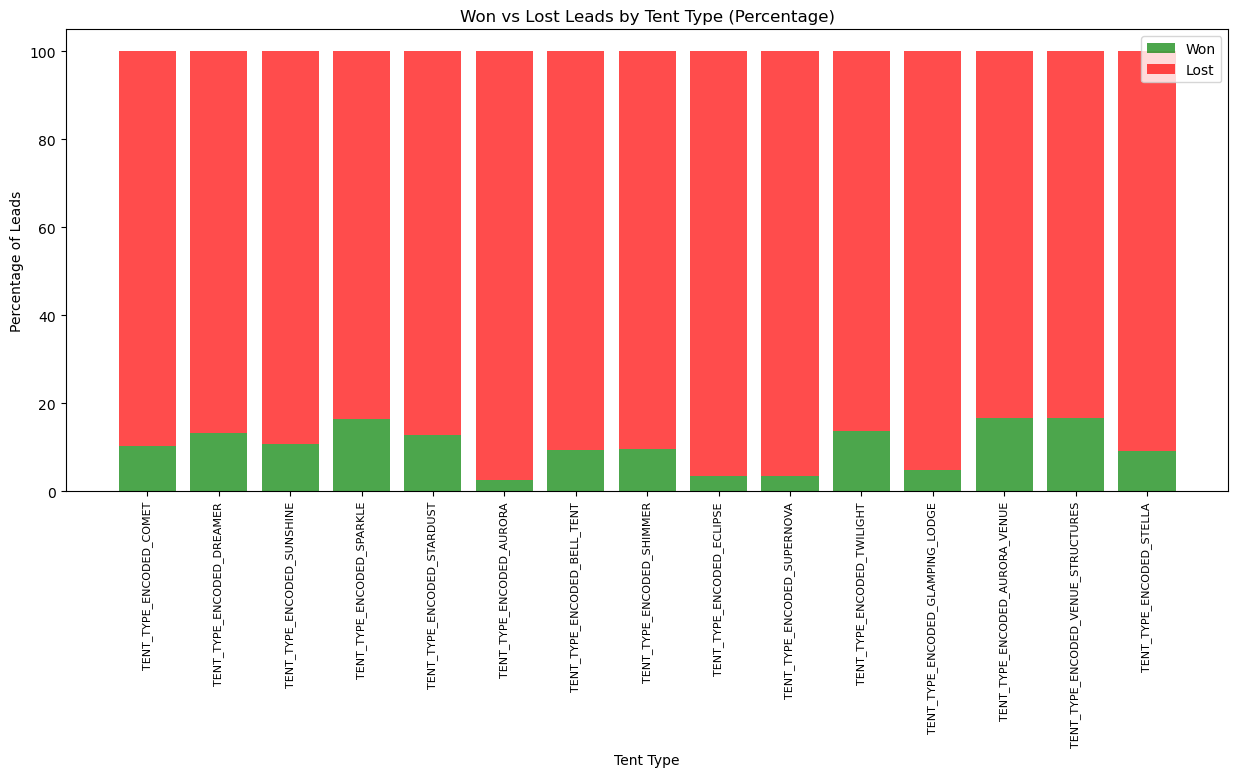

In [61]:
import matplotlib.pyplot as plt
import numpy as np

# Retrieve the columns containing the tent type values
tent_type_columns = [col for col in leads_df.columns if col.startswith('TENT_TYPE_ENCODED_')]
tent_type_columns = [col.replace('"', '') for col in tent_type_columns]

# Initialize dictionaries to store the counts
won_counts = {tent_type: won_leads[tent_type].sum() for tent_type in tent_type_columns}
lost_counts = {tent_type: lost_leads[tent_type].sum() for tent_type in tent_type_columns}

# Calculate total leads per tent type and sort tent types by total leads in descending order
total_leads = {tent_type: won_counts[tent_type] + lost_counts[tent_type] for tent_type in tent_type_columns}
sorted_tent_types = sorted(total_leads, key=total_leads.get, reverse=True)

# Calculate the percentage of won and lost leads for each tent type
won_percentages = [won_counts[tent_type] / total_leads[tent_type] * 100 if total_leads[tent_type] > 0 else 0 for tent_type in sorted_tent_types]
lost_percentages = [lost_counts[tent_type] / total_leads[tent_type] * 100 if total_leads[tent_type] > 0 else 0 for tent_type in sorted_tent_types]

# Create an array for the positions of the bars on the x-axis
x_pos = np.arange(len(sorted_tent_types))

# Plotting the histogram
plt.figure(figsize=(15, 6))

# Plot the 'Won' percentage for each tent type
plt.bar(x_pos, won_percentages, align='center', alpha=0.7, color='green', label='Won')

# Plot the 'Lost' percentage on top of 'Won' for each tent type
plt.bar(x_pos, lost_percentages, bottom=won_percentages, align='center', alpha=0.7, color='red', label='Lost')

# Add labels, title, and legend
plt.xlabel('Tent Type')
plt.ylabel('Percentage of Leads')
plt.title('Won vs Lost Leads by Tent Type (Percentage)')
plt.xticks(x_pos, sorted_tent_types, rotation='vertical', fontsize=8)
plt.legend()

# Show the plot
plt.show()

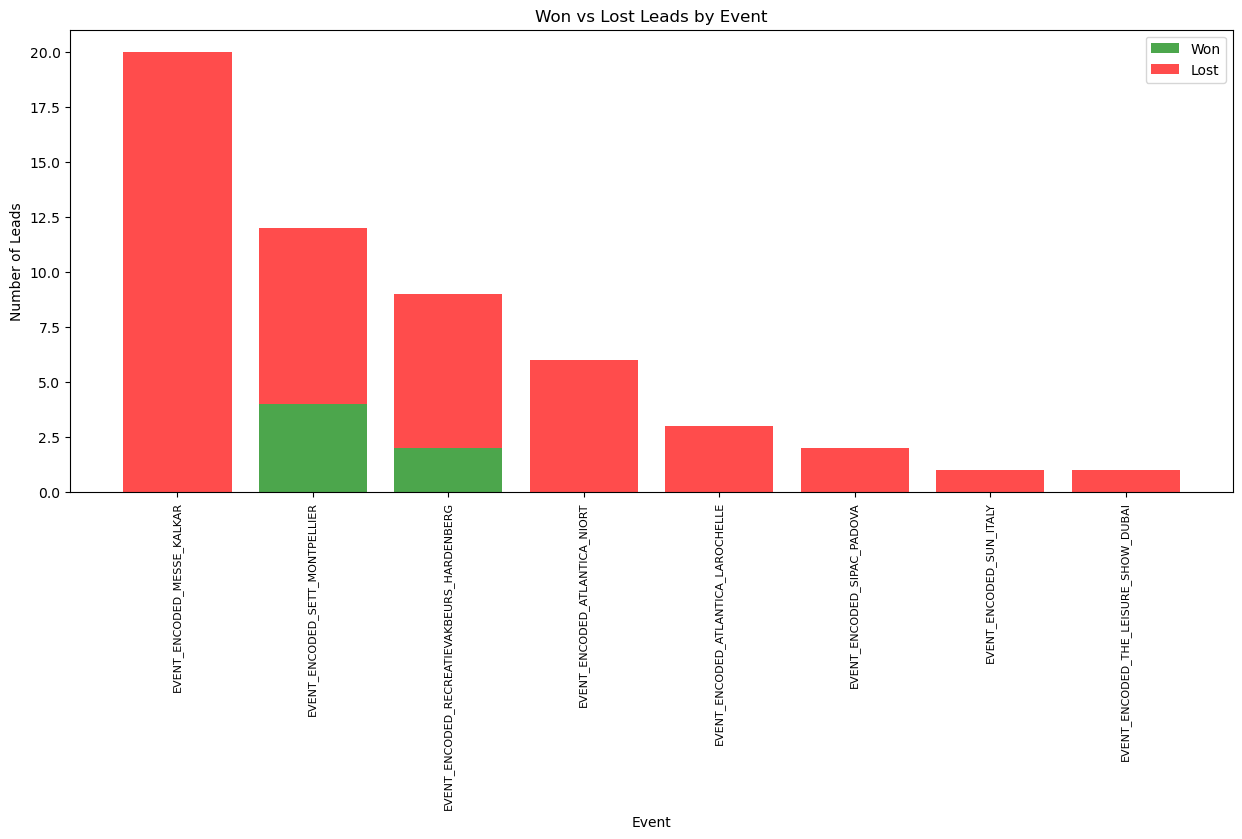

In [62]:
import matplotlib.pyplot as plt
import numpy as np

# Retrieve the columns containing the event values
event_columns = [col for col in leads_df.columns if col.startswith('EVENT_ENCODED_')]
event_columns = [col.replace('"', '') for col in event_columns]

# Initialize dictionaries to store the counts
won_counts = {event: won_leads[event].sum() for event in event_columns}
lost_counts = {event: lost_leads[event].sum() for event in event_columns}

# Calculate total leads per event and sort events by total leads in descending order
total_leads = {event: won_counts[event] + lost_counts[event] for event in event_columns}
sorted_events = sorted(total_leads, key=total_leads.get, reverse=True)

# Update the counts based on the sorted order
won_values = [won_counts[event] for event in sorted_events]
lost_values = [lost_counts[event] for event in sorted_events]

# Create an array for the positions of the bars on the x-axis
x_pos = np.arange(len(sorted_events))

# Plotting the histogram
plt.figure(figsize=(15, 6))

# Plot the 'Won' category for each event
plt.bar(x_pos, won_values, align='center', alpha=0.7, color='green', label='Won')

# Plot the 'Lost' category on top of 'Won' for each event
plt.bar(x_pos, lost_values, bottom=won_values, align='center', alpha=0.7, color='red', label='Lost')

# Add labels, title, and legend
plt.xlabel('Event')
plt.ylabel('Number of Leads')
plt.title('Won vs Lost Leads by Event')
plt.xticks(x_pos, sorted_events, rotation='vertical', fontsize=8)
plt.legend()

# Show the plot
plt.show()


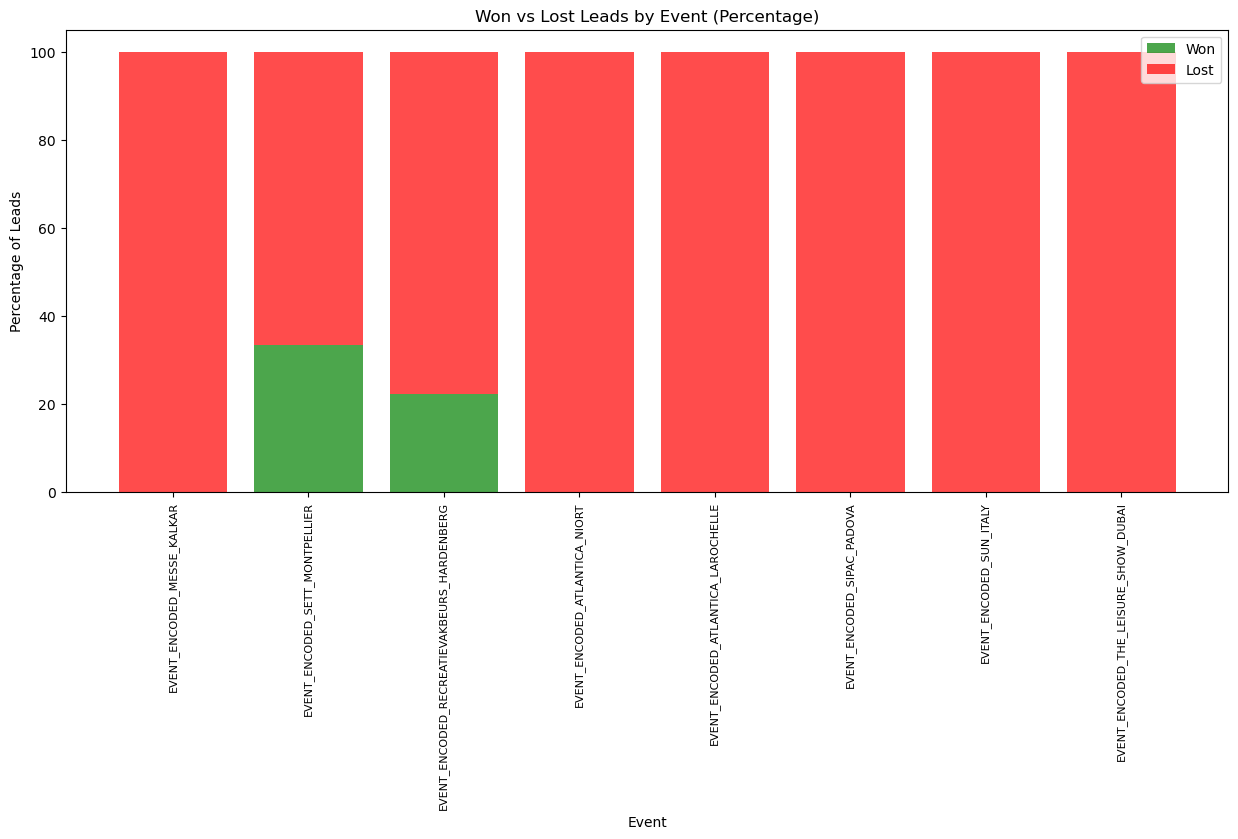

In [63]:
import matplotlib.pyplot as plt
import numpy as np

# Retrieve the columns containing the event values
event_columns = [col for col in leads_df.columns if col.startswith('EVENT_ENCODED_')]
event_columns = [col.replace('"', '') for col in event_columns]

# Initialize dictionaries to store the counts
won_counts = {event: won_leads[event].sum() for event in event_columns}
lost_counts = {event: lost_leads[event].sum() for event in event_columns}

# Calculate total leads per event and sort events by total leads in descending order
total_leads = {event: won_counts[event] + lost_counts[event] for event in event_columns}
sorted_events = sorted(total_leads, key=total_leads.get, reverse=True)

# Calculate the percentage of won and lost leads for each event
won_percentages = [won_counts[event] / total_leads[event] * 100 if total_leads[event] > 0 else 0 for event in sorted_events]
lost_percentages = [lost_counts[event] / total_leads[event] * 100 if total_leads[event] > 0 else 0 for event in sorted_events]

# Create an array for the positions of the bars on the x-axis
x_pos = np.arange(len(sorted_events))

# Plotting the histogram
plt.figure(figsize=(15, 6))

# Plot the 'Won' percentage for each event
plt.bar(x_pos, won_percentages, align='center', alpha=0.7, color='green', label='Won')

# Plot the 'Lost' percentage on top of 'Won' for each event
plt.bar(x_pos, lost_percentages, bottom=won_percentages, align='center', alpha=0.7, color='red', label='Lost')

# Add labels, title, and legend
plt.xlabel('Event')
plt.ylabel('Percentage of Leads')
plt.title('Won vs Lost Leads by Event (Percentage)')
plt.xticks(x_pos, sorted_events, rotation='vertical', fontsize=8)
plt.legend()

# Show the plot
plt.show()


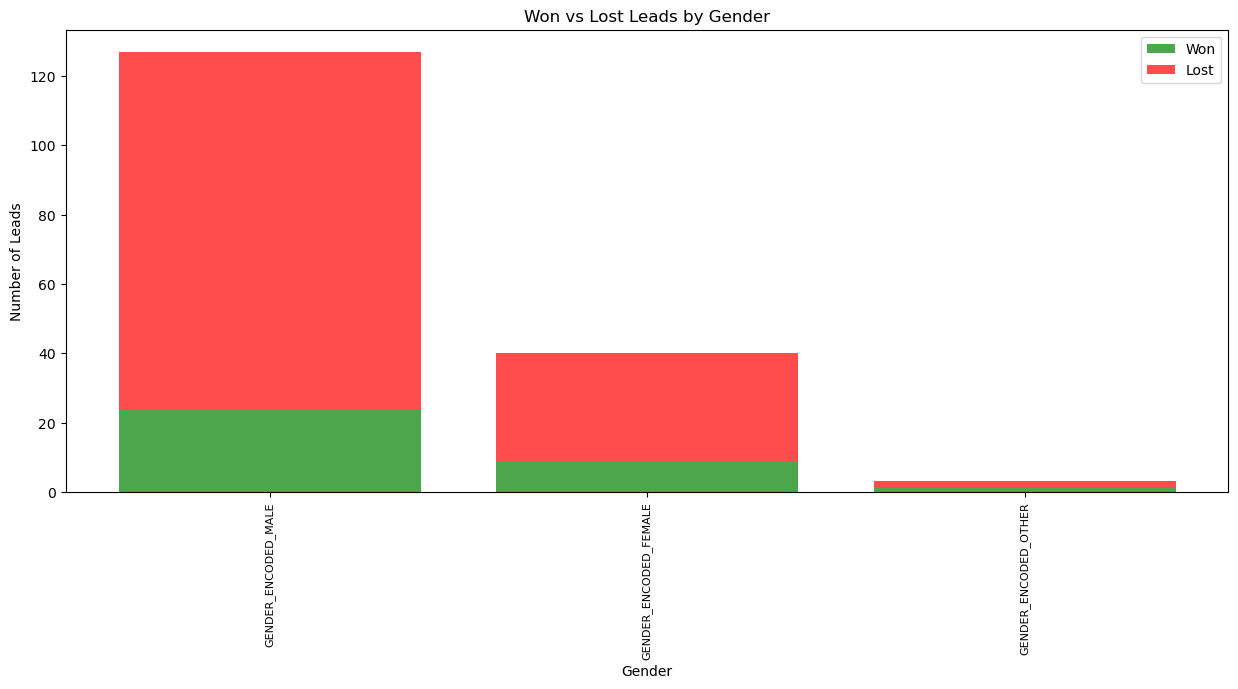

In [64]:
import matplotlib.pyplot as plt
import numpy as np

# Retrieve the columns containing the gender values
gender_columns = [col for col in leads_df.columns if col.startswith('GENDER_ENCODED_')]
gender_columns = [col.replace('"', '') for col in gender_columns]

# Initialize dictionaries to store the counts
won_counts = {gender: won_leads[gender].sum() for gender in gender_columns}
lost_counts = {gender: lost_leads[gender].sum() for gender in gender_columns}

# Calculate total leads per gender and sort genders by total leads in descending order
total_leads = {gender: won_counts[gender] + lost_counts[gender] for gender in gender_columns}
sorted_genders = sorted(total_leads, key=total_leads.get, reverse=True)

# Update the counts based on the sorted order
won_values = [won_counts[gender] for gender in sorted_genders]
lost_values = [lost_counts[gender] for gender in sorted_genders]

# Create an array for the positions of the bars on the x-axis
x_pos = np.arange(len(sorted_genders))

# Plotting the histogram
plt.figure(figsize=(15, 6))

# Plot the 'Won' category for each gender
plt.bar(x_pos, won_values, align='center', alpha=0.7, color='green', label='Won')

# Plot the 'Lost' category on top of 'Won' for each gender
plt.bar(x_pos, lost_values, bottom=won_values, align='center', alpha=0.7, color='red', label='Lost')

# Add labels, title, and legend
plt.xlabel('Gender')
plt.ylabel('Number of Leads')
plt.title('Won vs Lost Leads by Gender')
plt.xticks(x_pos, sorted_genders, rotation='vertical', fontsize=8)
plt.legend()

# Show the plot
plt.show()


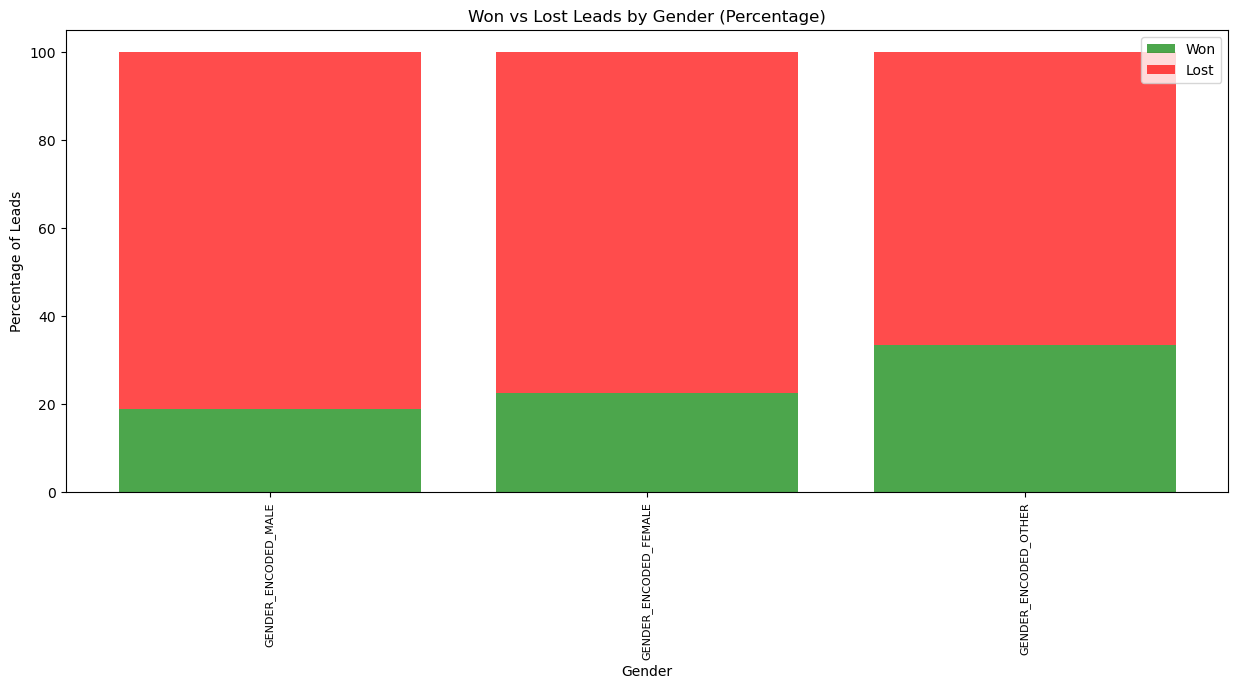

In [65]:
import matplotlib.pyplot as plt
import numpy as np

# Retrieve the columns containing the gender values
gender_columns = [col for col in leads_df.columns if col.startswith('GENDER_ENCODED_')]
gender_columns = [col.replace('"', '') for col in gender_columns]

# Initialize dictionaries to store the counts
won_counts = {gender: won_leads[gender].sum() for gender in gender_columns}
lost_counts = {gender: lost_leads[gender].sum() for gender in gender_columns}

# Calculate total leads per gender and sort genders by total leads in descending order
total_leads = {gender: won_counts[gender] + lost_counts[gender] for gender in gender_columns}
sorted_genders = sorted(total_leads, key=total_leads.get, reverse=True)

# Calculate the percentage of won and lost leads for each gender
won_percentages = [won_counts[gender] / total_leads[gender] * 100 if total_leads[gender] > 0 else 0 for gender in sorted_genders]
lost_percentages = [lost_counts[gender] / total_leads[gender] * 100 if total_leads[gender] > 0 else 0 for gender in sorted_genders]

# Create an array for the positions of the bars on the x-axis
x_pos = np.arange(len(sorted_genders))

# Plotting the histogram
plt.figure(figsize=(15, 6))

# Plot the 'Won' percentage for each gender
plt.bar(x_pos, won_percentages, align='center', alpha=0.7, color='green', label='Won')

# Plot the 'Lost' percentage on top of 'Won' for each gender
plt.bar(x_pos, lost_percentages, bottom=won_percentages, align='center', alpha=0.7, color='red', label='Lost')

# Add labels, title, and legend
plt.xlabel('Gender')
plt.ylabel('Percentage of Leads')
plt.title('Won vs Lost Leads by Gender (Percentage)')
plt.xticks(x_pos, sorted_genders, rotation='vertical', fontsize=8)
plt.legend()

# Show the plot
plt.show()


In [67]:
# Get sample input data to pass into the registry logging function
# X = train_df.select(CATEGORICAL_COLUMNS_OE+NUMERICAL_COLUMNS).limit(100)
X = leads_df_snowflake_test.select(feature_columns).limit(20)
# leads_df_snowflake_test_pd

db = identifier._get_unescaped_name(session.get_current_database())
schema = identifier._get_unescaped_name(session.get_current_schema())

# Define model name and version
model_name = "leads_model"
model_version = 1

# Create a registry and log the model
registry = model_registry.ModelRegistry(session=session, database_name=db, schema_name=schema, create_if_not_exists=True)

registry.log_model(
    model_name=model_name,
    model_version=model_version,
    model=xgb_classifier,
    sample_input_data=X,
    options={"embed_local_ml_library": True, # This option is enabled to pull latest dev code changes.
             "relax": True} # relax dependencies
)

# Add evaluation metric
# registry.set_metric(model_name=model_name, model_version=model_version, metric_name="mean_abs_pct_err", metric_value=optimal_mape)

create_model_registry() is in private preview since 0.2.0. Do not use it in production. 


In [68]:
# Let's confirm it was added
registry.list_models().to_pandas()


,CREATION_CONTEXT,CREATION_ENVIRONMENT_SPEC,CREATION_ROLE,CREATION_TIME,ID,INPUT_SPEC,NAME,OUTPUT_SPEC,RUNTIME_ENVIRONMENT_SPEC,TYPE,URI,VERSION,ARTIFACT_IDS,DESCRIPTION,METRICS,TAGS,REGISTRATION_TIMESTAMP
0,None,"{\n ""python"": ""3.9.0""\n}","""ACCOUNTADMIN""",2023-12-11 01:07:17.217000-08:00,a81dec66980411ee84b7b808cf535660,None,leads_model,None,None,snowml,sfc://YALA_DB.PUBLIC.SNOWML_MODEL_A81DEC669804...,1,None,None,None,None,2023-12-11 01:07:18.817000-08:00


In [71]:
registry.get_history().show()

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"EVENT_TIMESTAMP"                 |"EVENT_ID"                        |"MODEL_ID"                        |"ROLE"          |"OPERATION"  |"ATTRIBUTE_NAME"  |"VALUE[ATTRIBUTE_NAME]"                             |
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|2023-12-11 01:07:18.817000-08:00  |afc918dd980411ee8ba5b808cf535660  |a81dec66980411ee84b7b808cf535660  |"ACCOUNTADMIN"  |SET          |REGISTRATION      |{                                                   |
|                                  |                                  |                                  |                |             |                  |  "C

In [72]:
# Pick a deployment name and deploy
model_deployment_name = model_name + f"{model_version}" + "_UDF"

registry.deploy(model_name=model_name,
                model_version=model_version,
                deployment_name=model_deployment_name, 
                target_method="predict", 
                permanent=True, 
                options={"relax_version": True})

{'name': 'YALA_DB.PUBLIC.leads_model1_UDF',
 'platform': <TargetPlatform.WAREHOUSE: 'warehouse'>,
 'target_method': 'predict',
 'signature': ModelSignature(
                     inputs=[
                         FeatureSpec(dtype=DataType.INT8, name='CREATEDMONTH'),
 		FeatureSpec(dtype=DataType.INT8, name='CREATEDWEEK'),
 		FeatureSpec(dtype=DataType.INT8, name='CREATEDHOUR'),
 		FeatureSpec(dtype=DataType.INT8, name='CREATEDDAY'),
 		FeatureSpec(dtype=DataType.DOUBLE, name='LEN_LEADDESC_NORM'),
 		FeatureSpec(dtype=DataType.DOUBLE, name='LS_2973396'),
 		FeatureSpec(dtype=DataType.DOUBLE, name='LS_2973397'),
 		FeatureSpec(dtype=DataType.DOUBLE, name='LS_2973398'),
 		FeatureSpec(dtype=DataType.DOUBLE, name='LS_2985683'),
 		FeatureSpec(dtype=DataType.DOUBLE, name='LS_2985685'),
 		FeatureSpec(dtype=DataType.DOUBLE, name='LS_3306719'),
 		FeatureSpec(dtype=DataType.DOUBLE, name='LS_3306720'),
 		FeatureSpec(dtype=DataType.DOUBLE, name='LS_3314817'),
 		FeatureSpec(dtype=DataType.DOUB

In [73]:
# Let's confirm it was added
registry.list_deployments(model_name, model_version).to_pandas()

,MODEL_NAME,MODEL_VERSION,DEPLOYMENT_NAME,CREATION_TIME,TARGET_METHOD,TARGET_PLATFORM,SIGNATURE,OPTIONS,STAGE_PATH,ROLE
0,leads_model,1,leads_model1_UDF,2023-12-11 01:16:47.562000-08:00,predict,warehouse,"{\n ""inputs"": [\n {\n ""name"": ""CREATE...","{\n ""permanent_udf_stage_location"": ""@YALA_DB...",@YALA_DB.PUBLIC._SYSTEM_REGISTRY_DEPLOYMENTS_S...,"""ACCOUNTADMIN"""


In [74]:
# We can always get a reference to our registry using this function call
model_ref = model_registry.ModelReference(registry=registry, model_name=model_name, model_version=model_version)

# We can then use the deployed model to perform inference
result_sdf = model_ref.predict(deployment_name=model_deployment_name, data=leads_df_snowflake_test)
# result_sdf.rename(F.col('"output_feature_0"'),"PREDICTED_PRICE").show()

ValueError: (2112) Data Validation Error in feature LEN_LEADDESC_NORM: Feature type DataType.DOUBLE is not met by column LEN_LEADDESC_NORM.

In [ ]:
# country_columns
# country_columns = [col for col in leads_df_snowflake.columns 
#                            if col.startswith(('"AD_'))]
# country_df = leads_df_snowflake[country_columns]
# print(country_columns)
# country_df.show()

In [ ]:
shap.initjs()

In [ ]:
leads_df_snowflake_test_reordered = leads_df_snowflake_test[feature_columns]
instance_to_explain = leads_df_snowflake_test_reordered[feature_columns].iloc[26]
# Assuming instance_to_explain is a Pandas Series
instance_array = instance_to_explain.values.reshape(1, -1)
# Calculate SHAP values for this instance
shap_values_instance = explainer.shap_values(instance_array)
# Visualize the first prediction's explanation
shap.force_plot(explainer.expected_value, shap_values_instance, instance_to_explain)
# shap.summary_plot(explainer.expected_value, shap_values_instance, instance_to_explain)

In [ ]:
# Assuming xgb_classifier is your trained model and instance_to_explain is your data instance
# Reshape the instance data if necessary
instance_data = instance_to_explain.values.reshape(1, -1)

# Get the model's prediction for this instance
final_prediction = xgb_classifier.predict(instance_data)
print("Final Prediction for the instance:", final_prediction)


In [ ]:
# Create the decision plot
shap.decision_plot(explainer.expected_value, shap_values[26], instance_to_explain)

In [ ]:
print("Base value (expected value):", explainer.expected_value)

In [ ]:
# Convert the SHAP values for the instance into a DataFrame for easier interpretation
# shap_values_df = pd.DataFrame(shap_values_instance, columns=feature_columns)

# Display the DataFrame
# print(shap_values_df)


In [ ]:
probabilities = xgb_classifier.predict_proba(instance_data)
print("Probabilities for the instance:", probabilities)

In [ ]:
# Assuming 'xgb_classifier' is your trained XGBoost model
# and 'instance_to_explain' is the specific instance you want to explain

# Get the probability output for the instance
probabilities = xgb_classifier.predict_proba(instance_to_explain.values.reshape(1, -1))

# Print the probabilities
print(probabilities)
# print(instance_to_explain.to_csv())

In [ ]:
session.close()